# Make Figures for fourth section of Results

"3.4 Biogeochemical implications"

 - Figure 4

## imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask as da
from dask.diagnostics import ProgressBar
import gsw as gsw

# plotting packages
#import seaborn as sb
#sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import xesmf as xe 

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)

# activate the dask progress bar
#ProgressBar().register()

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


## load in the model data

In [2]:
%%time

temp = xr.open_dataset('JRA55_pic_1m_ts_1958-2022.nc')['thetao']
salt = xr.open_dataset('JRA55_pic_1m_ts_1958-2022.nc')['so']

tempSEp = xr.open_dataset('JRA55_SEPac_1m_grid_T_Y2022.nc')['thetao']
saltSEp = xr.open_dataset('JRA55_SEPac_1m_grid_T_Y2022.nc')['so']
tempSWp = xr.open_dataset('JRA55_SWPac_1m_grid_T_Y2022.nc')['thetao']
saltSWp = xr.open_dataset('JRA55_SWPac_1m_grid_T_Y2022.nc')['so']

tempSEi = xr.open_dataset('JRA55_SEInd_1m_grid_T_Y2022.nc')['thetao']
saltSEi = xr.open_dataset('JRA55_SEInd_1m_grid_T_Y2022.nc')['so']
tempSWi = xr.open_dataset('JRA55_SWInd_1m_grid_T_Y2022.nc')['thetao']
saltSWi = xr.open_dataset('JRA55_SWInd_1m_grid_T_Y2022.nc')['so']

files = ['JRA55_pic_1m_ptrc_T_1958-1967.nc',
         'JRA55_pic_1m_ptrc_T_1968-1977.nc',
         'JRA55_pic_1m_ptrc_T_1978-1987.nc',
         'JRA55_pic_1m_ptrc_T_1988-1997.nc',
         'JRA55_pic_1m_ptrc_T_1998-2007.nc',
         'JRA55_pic_1m_ptrc_T_2008-2017.nc',
         'JRA55_pic_1m_ptrc_T_2018-2022.nc']
age = xr.open_mfdataset(files, combine='nested', concat_dim='record')['Age']
dic = xr.open_mfdataset(files, combine='nested', concat_dim='record')['DIC']
no3 = xr.open_mfdataset(files, combine='nested', concat_dim='record')['NO3']
o2 = xr.open_mfdataset(files, combine='nested', concat_dim='record')['O2']

# Pacemaker experiments
ageSEi = xr.open_dataset('JRA55_SEInd_1m_ptrc_T_Y2022.nc')['Age']
dicSEi = xr.open_dataset('JRA55_SEInd_1m_ptrc_T_Y2022.nc')['DIC']
no3SEi = xr.open_dataset('JRA55_SEInd_1m_ptrc_T_Y2022.nc')['NO3']
o2SEi = xr.open_dataset('JRA55_SEInd_1m_ptrc_T_Y2022.nc')['O2']

ageSWi = xr.open_dataset('JRA55_SWInd_1m_ptrc_T_Y2022.nc')['Age']
dicSWi = xr.open_dataset('JRA55_SWInd_1m_ptrc_T_Y2022.nc')['DIC']
no3SWi = xr.open_dataset('JRA55_SWInd_1m_ptrc_T_Y2022.nc')['NO3']
o2SWi = xr.open_dataset('JRA55_SWInd_1m_ptrc_T_Y2022.nc')['O2']

ageSEp = xr.open_dataset('JRA55_SEPac_1m_ptrc_T_Y2022.nc')['Age']
dicSEp = xr.open_dataset('JRA55_SEPac_1m_ptrc_T_Y2022.nc')['DIC']
no3SEp = xr.open_dataset('JRA55_SEPac_1m_ptrc_T_Y2022.nc')['NO3']
o2SEp = xr.open_dataset('JRA55_SEPac_1m_ptrc_T_Y2022.nc')['O2']

ageSWp = xr.open_dataset('JRA55_SWPac_1m_ptrc_T_Y2022.nc')['Age']
dicSWp = xr.open_dataset('JRA55_SWPac_1m_ptrc_T_Y2022.nc')['DIC']
no3SWp = xr.open_dataset('JRA55_SWPac_1m_ptrc_T_Y2022.nc')['NO3']
o2SWp = xr.open_dataset('JRA55_SWPac_1m_ptrc_T_Y2022.nc')['O2']


CPU times: user 2 s, sys: 182 ms, total: 2.19 s
Wall time: 8.5 s


In [3]:
%%time

# grab the volume of grid cells on the tracer grid
data = xr.open_dataset('ORCA2.0.full_grid.nc')
lons = data['lon']
lats = data['lat']
lons_bnds = data['bounds_lon']
lats_bnds = data['bounds_lat']

data = xr.open_dataset('ORCA2_xyz_grid_T.nc')
dxt = data['e1t']
dyt = data['e2t']
dzt = data['e3t']
volume = dxt * dyt * dzt
area = dxt * dyt
depth = volume / area

data.close()


CPU times: user 17.3 ms, sys: 14.7 ms, total: 32 ms
Wall time: 332 ms


## rename some dimensions/coordinates

In [4]:

month = np.arange(1,13,1)
year = np.arange(1958.5,2022.51,1)

temp = temp.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
salt = salt.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
dept = temp * 0 + temp.coords['depth']

tempSEp = tempSEp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
saltSEp = saltSEp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
tempSWp = tempSWp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
saltSWp = saltSWp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
tempSEi = tempSEi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
saltSEi = saltSEi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
tempSWi = tempSWi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
saltSWi = saltSWi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})

deptSEp = tempSEp * 0 + tempSEp.coords['depth']
deptSWp = tempSWp * 0 + tempSWp.coords['depth']
deptSEi = tempSEi * 0 + tempSEi.coords['depth']
deptSWi = tempSWi * 0 + tempSWi.coords['depth']

age = age.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
dic = dic.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
no3 = no3.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
o2 = o2.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})

ageSEi = ageSEi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
dicSEi = dicSEi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
no3SEi = no3SEi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
o2SEi = o2SEi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})

ageSWi = ageSWi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
dicSWi = dicSWi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
no3SWi = no3SWi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
o2SWi = o2SWi.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})

ageSEp = ageSEp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
dicSEp = dicSEp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
no3SEp = no3SEp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
o2SEp = o2SEp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})

ageSWp = ageSWp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
dicSWp = dicSWp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
no3SWp = no3SWp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})
o2SWp = o2SWp.assign_coords(time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'time_counter':'month', 'deptht':'depth'})

volume = volume.rename({"deptht":"depth"})



## chunk the datasets

In [5]:
chunky = {'year':65, 'month':1, 'depth':31, 'y':149, 'x':182}
temp = temp.chunk(chunks=chunky).drop_vars('time_centered')
salt = salt.chunk(chunks=chunky).drop_vars('time_centered')
dept = dept.chunk(chunks=chunky).drop_vars('time_centered')
age = age.chunk(chunks=chunky).drop_vars('time_centered')
dic = dic.chunk(chunks=chunky).drop_vars('time_centered')
no3 = no3.chunk(chunks=chunky).drop_vars('time_centered')
o2 = o2.chunk(chunks=chunky).drop_vars('time_centered')


## Make new depth coordinate and regrid to a fine vertical resolution in the upper 2000 metres

In [6]:
%%time

new_depth = np.arange(5,2001,20)
new_depth_thick = np.arange(-5,2001,20)
new_depth_thick[0] = 0; new_depth_thick[-1] = 2000; 
new_depth_thick = np.diff(new_depth_thick)
print(len(new_depth), len(new_depth_thick))

new_depth_thick = new_depth_thick[:, np.newaxis, np.newaxis]
new_depth_thick = np.broadcast_to(new_depth_thick, (100,149,182))

dep_thick = xr.DataArray(
    new_depth_thick,
    dims=["depth", "y", "x"],
    coords={"depth": new_depth, "x":area.x, "y":area.y}
    )

vol = area.expand_dims({"depth": dep_thick.depth})
vol = vol * dep_thick

# regrid via cubic interpolation
salt_lin = salt.where(salt>0.0, other=np.nan).isel(depth=slice(0,25)).interp(depth=new_depth, method='linear')

temp = temp.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
dept = dept.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
dic = dic.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
no3 = no3.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
age = age.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
o2 = o2.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
salt = salt.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')

temp = temp.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))
dept = dept.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))
dic = dic.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))
no3 = no3.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))
age = age.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))
o2 = o2.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))
salt = salt.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))

temp_cub = temp.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
dept_cub = dept.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
dic_cub = dic.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
no3_cub = no3.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
age_cub = age.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
o2_cub = o2.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
salt_cub = salt.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)

saltSEp_lin = saltSEp.where(saltSEp>0.0, other=np.nan).isel(depth=slice(0,25)).interp(depth=new_depth, method='linear')
saltSWp_lin = saltSWp.where(saltSWp>0.0, other=np.nan).isel(depth=slice(0,25)).interp(depth=new_depth, method='linear')
saltSEi_lin = saltSEi.where(saltSEi>0.0, other=np.nan).isel(depth=slice(0,25)).interp(depth=new_depth, method='linear')
saltSWi_lin = saltSWi.where(saltSWi>0.0, other=np.nan).isel(depth=slice(0,25)).interp(depth=new_depth, method='linear')

tempSEi = tempSEi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
deptSEi = deptSEi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
dicSEi = dicSEi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
no3SEi = no3SEi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
ageSEi = ageSEi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
o2SEi = o2SEi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
saltSEi = saltSEi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
tempSWi = tempSWi.where(saltSWi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
deptSWi = deptSWi.where(saltSWi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
dicSWi = dicSWi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
no3SWi = no3SWi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
ageSWi = ageSWi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
o2SWi = o2SWi.where(saltSEi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
saltSWi = saltSWi.where(saltSWi>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')

tempSEp = tempSEp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
deptSEp = deptSEp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
dicSEp = dicSEp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
no3SEp = no3SEp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
ageSEp = ageSEp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
o2SEp = o2SEp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
saltSEp = saltSEp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
tempSWp = tempSWp.where(saltSWp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
deptSWp = deptSWp.where(saltSWp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
dicSWp = dicSWp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
no3SWp = no3SWp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
ageSWp = ageSWp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
o2SWp = o2SWp.where(saltSEp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
saltSWp = saltSWp.where(saltSWp>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')

tempSEi = tempSEi.where(~np.isnan(saltSEi),other=0.0).isel(depth=slice(0,25))
deptSEi = deptSEi.where(~np.isnan(saltSEi),other=0.0).isel(depth=slice(0,25))
dicSEi = dicSEi.where(~np.isnan(saltSEi),other=0.0).isel(depth=slice(0,25))
no3SEi = no3SEi.where(~np.isnan(saltSEi),other=0.0).isel(depth=slice(0,25))
ageSEi = ageSEi.where(~np.isnan(saltSEi),other=0.0).isel(depth=slice(0,25))
o2SEi = o2SEi.where(~np.isnan(saltSEi),other=0.0).isel(depth=slice(0,25))
saltSEi = saltSEi.where(~np.isnan(saltSEi),other=0.0).isel(depth=slice(0,25))
tempSWi = tempSWi.where(~np.isnan(saltSWi),other=0.0).isel(depth=slice(0,25))
deptSWi = deptSWi.where(~np.isnan(saltSWi),other=0.0).isel(depth=slice(0,25))
dicSWi = dicSWi.where(~np.isnan(saltSWi),other=0.0).isel(depth=slice(0,25))
no3SWi = no3SWi.where(~np.isnan(saltSWi),other=0.0).isel(depth=slice(0,25))
ageSWi = ageSWi.where(~np.isnan(saltSWi),other=0.0).isel(depth=slice(0,25))
o2SWi = o2SWi.where(~np.isnan(saltSWi),other=0.0).isel(depth=slice(0,25))
saltSWi = saltSWi.where(~np.isnan(saltSWi),other=0.0).isel(depth=slice(0,25))

tempSEp = tempSEp.where(~np.isnan(saltSEp),other=0.0).isel(depth=slice(0,25))
deptSEp = deptSEp.where(~np.isnan(saltSEp),other=0.0).isel(depth=slice(0,25))
dicSEp = dicSEp.where(~np.isnan(saltSEp),other=0.0).isel(depth=slice(0,25))
no3SEp = no3SEp.where(~np.isnan(saltSEp),other=0.0).isel(depth=slice(0,25))
ageSEp = ageSEp.where(~np.isnan(saltSEp),other=0.0).isel(depth=slice(0,25))
o2SEp = o2SEp.where(~np.isnan(saltSEp),other=0.0).isel(depth=slice(0,25))
saltSEp = saltSEp.where(~np.isnan(saltSEp),other=0.0).isel(depth=slice(0,25))
tempSWp = tempSWp.where(~np.isnan(saltSWp),other=0.0).isel(depth=slice(0,25))
deptSWp = deptSWp.where(~np.isnan(saltSWp),other=0.0).isel(depth=slice(0,25))
dicSWp = dicSWp.where(~np.isnan(saltSWp),other=0.0).isel(depth=slice(0,25))
no3SWp = no3SWp.where(~np.isnan(saltSWp),other=0.0).isel(depth=slice(0,25))
ageSWp = ageSWp.where(~np.isnan(saltSWp),other=0.0).isel(depth=slice(0,25))
o2SWp = o2SWp.where(~np.isnan(saltSWp),other=0.0).isel(depth=slice(0,25))
saltSWp = saltSWp.where(~np.isnan(saltSWp),other=0.0).isel(depth=slice(0,25))

tempSEi_cub = tempSEi.interp(depth=new_depth, method='cubic').where(saltSEi_lin>0.0, other=np.nan)
deptSEi_cub = deptSEi.interp(depth=new_depth, method='cubic').where(saltSEi_lin>0.0, other=np.nan)
dicSEi_cub = dicSEi.interp(depth=new_depth, method='cubic').where(saltSEi_lin>0.0, other=np.nan)
no3SEi_cub = no3SEi.interp(depth=new_depth, method='cubic').where(saltSEi_lin>0.0, other=np.nan)
ageSEi_cub = ageSEi.interp(depth=new_depth, method='cubic').where(saltSEi_lin>0.0, other=np.nan)
o2SEi_cub = o2SEi.interp(depth=new_depth, method='cubic').where(saltSEi_lin>0.0, other=np.nan)
saltSEi_cub = saltSEi.interp(depth=new_depth, method='cubic').where(saltSEi_lin>0.0, other=np.nan)
tempSWi_cub = tempSWi.interp(depth=new_depth, method='cubic').where(saltSWi_lin>0.0, other=np.nan)
deptSWi_cub = deptSWi.interp(depth=new_depth, method='cubic').where(saltSWi_lin>0.0, other=np.nan)
dicSWi_cub = dicSWi.interp(depth=new_depth, method='cubic').where(saltSWi_lin>0.0, other=np.nan)
no3SWi_cub = no3SWi.interp(depth=new_depth, method='cubic').where(saltSWi_lin>0.0, other=np.nan)
ageSWi_cub = ageSWi.interp(depth=new_depth, method='cubic').where(saltSWi_lin>0.0, other=np.nan)
o2SWi_cub = o2SWi.interp(depth=new_depth, method='cubic').where(saltSWi_lin>0.0, other=np.nan)
saltSWi_cub = saltSWi.interp(depth=new_depth, method='cubic').where(saltSWi_lin>0.0, other=np.nan)

tempSEp_cub = tempSEp.interp(depth=new_depth, method='cubic').where(saltSEp_lin>0.0, other=np.nan)
deptSEp_cub = deptSEp.interp(depth=new_depth, method='cubic').where(saltSEp_lin>0.0, other=np.nan)
dicSEp_cub = dicSEp.interp(depth=new_depth, method='cubic').where(saltSEp_lin>0.0, other=np.nan)
no3SEp_cub = no3SEp.interp(depth=new_depth, method='cubic').where(saltSEp_lin>0.0, other=np.nan)
ageSEp_cub = ageSEp.interp(depth=new_depth, method='cubic').where(saltSEp_lin>0.0, other=np.nan)
o2SEp_cub = o2SEp.interp(depth=new_depth, method='cubic').where(saltSEp_lin>0.0, other=np.nan)
saltSEp_cub = saltSEp.interp(depth=new_depth, method='cubic').where(saltSEp_lin>0.0, other=np.nan)
tempSWp_cub = tempSWp.interp(depth=new_depth, method='cubic').where(saltSWp_lin>0.0, other=np.nan)
deptSWp_cub = deptSWp.interp(depth=new_depth, method='cubic').where(saltSWp_lin>0.0, other=np.nan)
dicSWp_cub = dicSWp.interp(depth=new_depth, method='cubic').where(saltSWp_lin>0.0, other=np.nan)
no3SWp_cub = no3SWp.interp(depth=new_depth, method='cubic').where(saltSWp_lin>0.0, other=np.nan)
ageSWp_cub = ageSWp.interp(depth=new_depth, method='cubic').where(saltSWp_lin>0.0, other=np.nan)
o2SWp_cub = o2SWp.interp(depth=new_depth, method='cubic').where(saltSWp_lin>0.0, other=np.nan)
saltSWp_cub = saltSWp.interp(depth=new_depth, method='cubic').where(saltSWp_lin>0.0, other=np.nan)


100 100
CPU times: user 3min 4s, sys: 4.63 s, total: 3min 9s
Wall time: 3min 47s


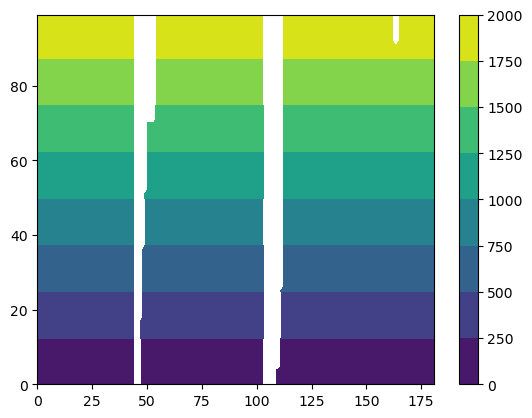

In [7]:
plt.figure()
p1 = plt.contourf(deptSEp_cub.isel(month=7,y=40))
plt.colorbar(p1)


## Calculate density

In [8]:
%%time

rho0_cub = gsw.density.sigma0(salt_cub, temp_cub)
rho0SEp_cub = gsw.density.sigma0(saltSEp_cub, tempSEp_cub)
rho0SWp_cub = gsw.density.sigma0(saltSWp_cub, tempSWp_cub)
rho0SEi_cub = gsw.density.sigma0(saltSEi_cub, tempSEi_cub)
rho0SWi_cub = gsw.density.sigma0(saltSWi_cub, tempSWi_cub)

# mask rho0 where there are zeros
rho0_cub = rho0_cub.where(rho0_cub > 0.0, other=np.nan)
rho0SEp_cub = rho0SEp_cub.where(rho0SEp_cub > 0.0, other=np.nan)
rho0SWp_cub = rho0SWp_cub.where(rho0SWp_cub > 0.0, other=np.nan)
rho0SEi_cub = rho0SEi_cub.where(rho0SEi_cub > 0.0, other=np.nan)
rho0SWi_cub = rho0SWi_cub.where(rho0SWi_cub > 0.0, other=np.nan)


CPU times: user 1.61 s, sys: 142 ms, total: 1.75 s
Wall time: 1.76 s


## Vertical gradient in potential density

In [9]:
%%time

dpdz_cub = rho0_cub.differentiate('depth')

dpdzSEp_cub = rho0SEp_cub.differentiate('depth')
dpdzSWp_cub = rho0SWp_cub.differentiate('depth')

dpdzSEi_cub = rho0SEi_cub.differentiate('depth')
dpdzSWi_cub = rho0SWi_cub.differentiate('depth')


CPU times: user 234 ms, sys: 123 ms, total: 358 ms
Wall time: 359 ms


## calculate the "thermostad", the change in depth per degree C

-101.99998 -44.646076
CPU times: user 393 ms, sys: 270 ms, total: 663 ms
Wall time: 665 ms


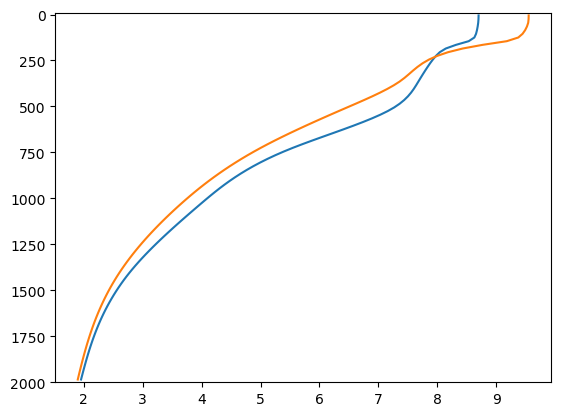

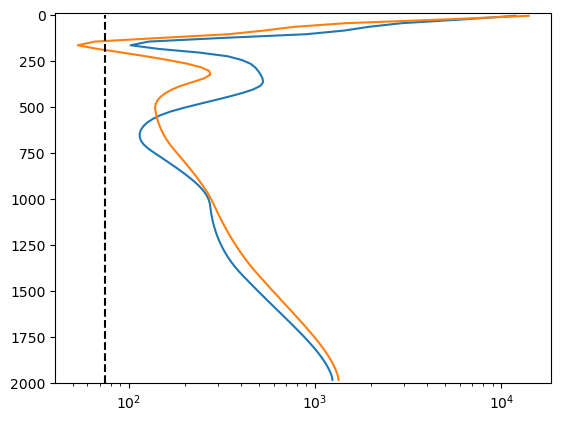

In [10]:
%%time 

dtdz_cub = temp_cub.differentiate('depth')
dzdt_cub = np.abs(1.0/dtdz_cub)

dtdzSEp_cub = tempSEp_cub.differentiate('depth')
dzdtSEp_cub = np.abs(1.0/dtdzSEp_cub)
dtdzSWp_cub = tempSWp_cub.differentiate('depth')
dzdtSWp_cub = np.abs(1.0/dtdzSWp_cub)

dtdzSEi_cub = tempSEi_cub.differentiate('depth')
dzdtSEi_cub = np.abs(1.0/dtdzSEi_cub)
dtdzSWi_cub = tempSWi_cub.differentiate('depth')
dzdtSWi_cub = np.abs(1.0/dtdzSWi_cub)

xx = 90; yy = 40
print(tempSEp_cub.coords['lon'].isel(x=xx,y=yy).values, tempSEp_cub.coords['lat'].isel(x=xx,y=yy).values)

plt.figure()
plt.plot(tempSEp_cub.isel(month=7,x=xx,y=yy), tempSEp_cub.coords['depth'])
plt.plot(tempSWp_cub.isel(month=7,x=xx,y=yy), tempSWp_cub.coords['depth'])
plt.ylim(2000,-10)

plt.figure()
plt.plot(np.abs(dzdtSEp_cub.isel(month=7,x=xx,y=yy)), dtdzSEp_cub.coords['depth'])
plt.plot(np.abs(dzdtSWp_cub.isel(month=7,x=xx,y=yy)), dtdzSWp_cub.coords['depth'])
plt.ylim(2000,-10)
plt.plot((75,75), (2000,0), 'k--')
plt.xscale('log')



## get the isopycnal bounds and select grid cells belonging to SAMW

In [11]:
### set bounds for SAMW
samw_rho0_bnds = np.array([26.5, 27.1])
samw_lati_bnds = np.array([-90., -20.])
samw_dzdt_bnds = np.array([75.0])


## identify SAMW

In [12]:
%%time

samw_cub = rho0_cub*0 + 1.0
samw_cub = samw_cub.where(rho0_cub > samw_rho0_bnds[0], other=0.0).where(rho0_cub < samw_rho0_bnds[1], other=0.0)
samw_cub = samw_cub.where(samw_cub.coords['lat'] > samw_lati_bnds[0], other=0.0).where(samw_cub.coords['lat'] < samw_lati_bnds[1], other=0.0)
samw_cub = samw_cub.where(dzdt_cub > samw_dzdt_bnds[0], other=0.0)
samw_cub_volume = (samw_cub * vol).drop_vars(['nav_lon', 'nav_lat'])    # m3

samwSEp_cub = rho0SEp_cub*0 + 1.0
samwSEp_cub = samwSEp_cub.where(rho0SEp_cub > samw_rho0_bnds[0], other=0.0).where(rho0SEp_cub < samw_rho0_bnds[1], other=0.0)
samwSEp_cub = samwSEp_cub.where(samwSEp_cub.coords['lat'] > samw_lati_bnds[0], other=0.0).where(samwSEp_cub.coords['lat'] < samw_lati_bnds[1], other=0.0)
samwSEp_cub = samwSEp_cub.where(dzdtSEp_cub > samw_dzdt_bnds[0], other=0.0)
samwSEp_cub_volume = (samwSEp_cub * vol).drop_vars(['nav_lon', 'nav_lat'])    # m3

samwSWp_cub = rho0SWp_cub*0 + 1.0
samwSWp_cub = samwSWp_cub.where(rho0SWp_cub > samw_rho0_bnds[0], other=0.0).where(rho0SWp_cub < samw_rho0_bnds[1], other=0.0)
samwSWp_cub = samwSWp_cub.where(samwSWp_cub.coords['lat'] > samw_lati_bnds[0], other=0.0).where(samwSWp_cub.coords['lat'] < samw_lati_bnds[1], other=0.0)
samwSWp_cub = samwSWp_cub.where(dzdtSWp_cub > samw_dzdt_bnds[0], other=0.0)
samwSWp_cub_volume = (samwSWp_cub * vol).drop_vars(['nav_lon', 'nav_lat'])    # m3

samwSEi_cub = rho0SEi_cub*0 + 1.0
samwSEi_cub = samwSEi_cub.where(rho0SEi_cub > samw_rho0_bnds[0], other=0.0).where(rho0SEi_cub < samw_rho0_bnds[1], other=0.0)
samwSEi_cub = samwSEi_cub.where(samwSEi_cub.coords['lat'] > samw_lati_bnds[0], other=0.0).where(samwSEi_cub.coords['lat'] < samw_lati_bnds[1], other=0.0)
samwSEi_cub = samwSEi_cub.where(dzdtSEi_cub > samw_dzdt_bnds[0], other=0.0)
samwSEi_cub_volume = (samwSEi_cub * vol).drop_vars(['nav_lon', 'nav_lat'])    # m3

samwSWi_cub = rho0SWi_cub*0 + 1.0
samwSWi_cub = samwSWi_cub.where(rho0SWi_cub > samw_rho0_bnds[0], other=0.0).where(rho0SWi_cub < samw_rho0_bnds[1], other=0.0)
samwSWi_cub = samwSWi_cub.where(samwSWi_cub.coords['lat'] > samw_lati_bnds[0], other=0.0).where(samwSWi_cub.coords['lat'] < samw_lati_bnds[1], other=0.0)
samwSWi_cub = samwSWi_cub.where(dzdtSWi_cub > samw_dzdt_bnds[0], other=0.0)
samwSWi_cub_volume = (samwSWi_cub * vol).drop_vars(['nav_lon', 'nav_lat'])    # m3



CPU times: user 1.16 s, sys: 569 ms, total: 1.73 s
Wall time: 1.74 s


## identify properties in SAMW

In [13]:
%%time

tem_samw = temp_cub.where(samw_cub > 0.0, other=np.nan)
dep_samw = dept_cub.where(samw_cub > 0.0, other=np.nan)
sal_samw = salt_cub.where(samw_cub > 0.0, other=np.nan)
age_samw = age_cub.where(samw_cub > 0.0, other=np.nan)
o2_samw = o2_cub.where(samw_cub > 0.0, other=np.nan)
dic_samw = dic_cub.where(samw_cub > 0.0, other=np.nan)
no3_samw = no3_cub.where(samw_cub > 0.0, other=np.nan)
temSEp_samw = tempSEp_cub.where(samwSEp_cub > 0.0, other=np.nan)
depSEp_samw = deptSEp_cub.where(samwSEp_cub > 0.0, other=np.nan)
salSEp_samw = saltSEp_cub.where(samwSEp_cub > 0.0, other=np.nan)
ageSEp_samw = ageSEp_cub.where(samwSEp_cub > 0.0, other=np.nan)
o2SEp_samw = o2SEp_cub.where(samwSEp_cub > 0.0, other=np.nan)
dicSEp_samw = dicSEp_cub.where(samwSEp_cub > 0.0, other=np.nan)
no3SEp_samw = no3SEp_cub.where(samwSEp_cub > 0.0, other=np.nan)
temSWp_samw = tempSWp_cub.where(samwSWp_cub > 0.0, other=np.nan)
depSWp_samw = deptSWp_cub.where(samwSWp_cub > 0.0, other=np.nan)
salSWp_samw = saltSWp_cub.where(samwSWp_cub > 0.0, other=np.nan)
ageSWp_samw = ageSWp_cub.where(samwSWp_cub > 0.0, other=np.nan)
o2SWp_samw = o2SWp_cub.where(samwSWp_cub > 0.0, other=np.nan)
dicSWp_samw = dicSWp_cub.where(samwSWp_cub > 0.0, other=np.nan)
no3SWp_samw = no3SWp_cub.where(samwSWp_cub > 0.0, other=np.nan)
temSEi_samw = tempSEi_cub.where(samwSEi_cub > 0.0, other=np.nan)
depSEi_samw = deptSEi_cub.where(samwSEi_cub > 0.0, other=np.nan)
salSEi_samw = saltSEi_cub.where(samwSEi_cub > 0.0, other=np.nan)
ageSEi_samw = ageSEi_cub.where(samwSEi_cub > 0.0, other=np.nan)
o2SEi_samw = o2SEi_cub.where(samwSEi_cub > 0.0, other=np.nan)
dicSEi_samw = dicSEi_cub.where(samwSEi_cub > 0.0, other=np.nan)
no3SEi_samw = no3SEi_cub.where(samwSEi_cub > 0.0, other=np.nan)
temSWi_samw = tempSWi_cub.where(samwSWi_cub > 0.0, other=np.nan)
depSWi_samw = deptSWi_cub.where(samwSWi_cub > 0.0, other=np.nan)
salSWi_samw = saltSWi_cub.where(samwSWi_cub > 0.0, other=np.nan)
ageSWi_samw = ageSWi_cub.where(samwSWi_cub > 0.0, other=np.nan)
o2SWi_samw = o2SWi_cub.where(samwSWi_cub > 0.0, other=np.nan)
dicSWi_samw = dicSWi_cub.where(samwSWi_cub > 0.0, other=np.nan)
no3SWi_samw = no3SWi_cub.where(samwSWi_cub > 0.0, other=np.nan)

# find properties in the upper limb of SAMW (26.5 to 26.7 kg/m3)
tem_Usamw = temp_cub.where((rho0_cub > 26.5) & (rho0_cub < 26.7), other=np.nan)
dep_Usamw = dept_cub.where((rho0_cub > 26.5) & (rho0_cub < 26.7), other=np.nan)
sal_Usamw = salt_cub.where((rho0_cub > 26.5) & (rho0_cub < 26.7), other=np.nan)
age_Usamw = age_cub.where((rho0_cub > 26.5) & (rho0_cub < 26.7), other=np.nan)
o2_Usamw = o2_cub.where((rho0_cub > 26.5) & (rho0_cub < 26.7), other=np.nan)
dic_Usamw = dic_cub.where((rho0_cub > 26.5) & (rho0_cub < 26.7), other=np.nan)
no3_Usamw = no3_cub.where((rho0_cub > 26.5) & (rho0_cub < 26.7), other=np.nan)
temSEp_Usamw = tempSEp_cub.where((rho0SEp_cub > 26.5) & (rho0SEp_cub < 26.7), other=np.nan)
depSEp_Usamw = deptSEp_cub.where((rho0SEp_cub > 26.5) & (rho0SEp_cub < 26.7), other=np.nan)
salSEp_Usamw = saltSEp_cub.where((rho0SEp_cub > 26.5) & (rho0SEp_cub < 26.7), other=np.nan)
ageSEp_Usamw = ageSEp_cub.where((rho0SEp_cub > 26.5) & (rho0SEp_cub < 26.7), other=np.nan)
o2SEp_Usamw = o2SEp_cub.where((rho0SEp_cub > 26.5) & (rho0SEp_cub < 26.7), other=np.nan)
dicSEp_Usamw = dicSEp_cub.where((rho0SEp_cub > 26.5) & (rho0SEp_cub < 26.7), other=np.nan)
no3SEp_Usamw = no3SEp_cub.where((rho0SEp_cub > 26.5) & (rho0SEp_cub < 26.7), other=np.nan)
temSWp_Usamw = tempSWp_cub.where((rho0SWp_cub > 26.5) & (rho0SWp_cub < 26.7), other=np.nan)
depSWp_Usamw = deptSWp_cub.where((rho0SWp_cub > 26.5) & (rho0SWp_cub < 26.7), other=np.nan)
salSWp_Usamw = saltSWp_cub.where((rho0SWp_cub > 26.5) & (rho0SWp_cub < 26.7), other=np.nan)
ageSWp_Usamw = ageSWp_cub.where((rho0SWp_cub > 26.5) & (rho0SWp_cub < 26.7), other=np.nan)
o2SWp_Usamw = o2SWp_cub.where((rho0SWp_cub > 26.5) & (rho0SWp_cub < 26.7), other=np.nan)
dicSWp_Usamw = dicSWp_cub.where((rho0SWp_cub > 26.5) & (rho0SWp_cub < 26.7), other=np.nan)
no3SWp_Usamw = no3SWp_cub.where((rho0SWp_cub > 26.5) & (rho0SWp_cub < 26.7), other=np.nan)
temSEi_Usamw = tempSEi_cub.where((rho0SEi_cub > 26.5) & (rho0SEi_cub < 26.7), other=np.nan)
depSEi_Usamw = deptSEi_cub.where((rho0SEi_cub > 26.5) & (rho0SEi_cub < 26.7), other=np.nan)
salSEi_Usamw = saltSEi_cub.where((rho0SEi_cub > 26.5) & (rho0SEi_cub < 26.7), other=np.nan)
ageSEi_Usamw = ageSEi_cub.where((rho0SEi_cub > 26.5) & (rho0SEi_cub < 26.7), other=np.nan)
o2SEi_Usamw = o2SEi_cub.where((rho0SEi_cub > 26.5) & (rho0SEi_cub < 26.7), other=np.nan)
dicSEi_Usamw = dicSEi_cub.where((rho0SEi_cub > 26.5) & (rho0SEi_cub < 26.7), other=np.nan)
no3SEi_Usamw = no3SEi_cub.where((rho0SEi_cub > 26.5) & (rho0SEi_cub < 26.7), other=np.nan)
temSWi_Usamw = tempSWi_cub.where((rho0SWi_cub > 26.5) & (rho0SWi_cub < 26.7), other=np.nan)
depSWi_Usamw = deptSWi_cub.where((rho0SWi_cub > 26.5) & (rho0SWi_cub < 26.7), other=np.nan)
salSWi_Usamw = saltSWi_cub.where((rho0SWi_cub > 26.5) & (rho0SWi_cub < 26.7), other=np.nan)
ageSWi_Usamw = ageSWi_cub.where((rho0SWi_cub > 26.5) & (rho0SWi_cub < 26.7), other=np.nan)
o2SWi_Usamw = o2SWi_cub.where((rho0SWi_cub > 26.5) & (rho0SWi_cub < 26.7), other=np.nan)
dicSWi_Usamw = dicSWi_cub.where((rho0SWi_cub > 26.5) & (rho0SWi_cub < 26.7), other=np.nan)
no3SWi_Usamw = no3SWi_cub.where((rho0SWi_cub > 26.5) & (rho0SWi_cub < 26.7), other=np.nan)

# find properties in the center limb of SAMW (26.7 to 26.9 kg/m3)
tem_Csamw = temp_cub.where((rho0_cub > 26.7) & (rho0_cub < 26.9), other=np.nan)
dep_Csamw = dept_cub.where((rho0_cub > 26.7) & (rho0_cub < 26.9), other=np.nan)
sal_Csamw = salt_cub.where((rho0_cub > 26.7) & (rho0_cub < 26.9), other=np.nan)
age_Csamw = age_cub.where((rho0_cub > 26.7) & (rho0_cub < 26.9), other=np.nan)
o2_Csamw = o2_cub.where((rho0_cub > 26.7) & (rho0_cub < 26.9), other=np.nan)
dic_Csamw = dic_cub.where((rho0_cub > 26.7) & (rho0_cub < 26.9), other=np.nan)
no3_Csamw = no3_cub.where((rho0_cub > 26.7) & (rho0_cub < 26.9), other=np.nan)
temSEp_Csamw = tempSEp_cub.where((rho0SEp_cub > 26.7) & (rho0SEp_cub < 26.9), other=np.nan)
depSEp_Csamw = deptSEp_cub.where((rho0SEp_cub > 26.7) & (rho0SEp_cub < 26.9), other=np.nan)
salSEp_Csamw = saltSEp_cub.where((rho0SEp_cub > 26.7) & (rho0SEp_cub < 26.9), other=np.nan)
ageSEp_Csamw = ageSEp_cub.where((rho0SEp_cub > 26.7) & (rho0SEp_cub < 26.9), other=np.nan)
o2SEp_Csamw = o2SEp_cub.where((rho0SEp_cub > 26.7) & (rho0SEp_cub < 26.9), other=np.nan)
dicSEp_Csamw = dicSEp_cub.where((rho0SEp_cub > 26.7) & (rho0SEp_cub < 26.9), other=np.nan)
no3SEp_Csamw = no3SEp_cub.where((rho0SEp_cub > 26.7) & (rho0SEp_cub < 26.9), other=np.nan)
temSWp_Csamw = tempSWp_cub.where((rho0SWp_cub > 26.7) & (rho0SWp_cub < 26.9), other=np.nan)
depSWp_Csamw = deptSWp_cub.where((rho0SWp_cub > 26.7) & (rho0SWp_cub < 26.9), other=np.nan)
salSWp_Csamw = saltSWp_cub.where((rho0SWp_cub > 26.7) & (rho0SWp_cub < 26.9), other=np.nan)
ageSWp_Csamw = ageSWp_cub.where((rho0SWp_cub > 26.7) & (rho0SWp_cub < 26.9), other=np.nan)
o2SWp_Csamw = o2SWp_cub.where((rho0SWp_cub > 26.7) & (rho0SWp_cub < 26.9), other=np.nan)
dicSWp_Csamw = dicSWp_cub.where((rho0SWp_cub > 26.7) & (rho0SWp_cub < 26.9), other=np.nan)
no3SWp_Csamw = no3SWp_cub.where((rho0SWp_cub > 26.7) & (rho0SWp_cub < 26.9), other=np.nan)
temSEi_Csamw = tempSEi_cub.where((rho0SEi_cub > 26.7) & (rho0SEi_cub < 26.9), other=np.nan)
depSEi_Csamw = deptSEi_cub.where((rho0SEi_cub > 26.7) & (rho0SEi_cub < 26.9), other=np.nan)
salSEi_Csamw = saltSEi_cub.where((rho0SEi_cub > 26.7) & (rho0SEi_cub < 26.9), other=np.nan)
ageSEi_Csamw = ageSEi_cub.where((rho0SEi_cub > 26.7) & (rho0SEi_cub < 26.9), other=np.nan)
o2SEi_Csamw = o2SEi_cub.where((rho0SEi_cub > 26.7) & (rho0SEi_cub < 26.9), other=np.nan)
dicSEi_Csamw = dicSEi_cub.where((rho0SEi_cub > 26.7) & (rho0SEi_cub < 26.9), other=np.nan)
no3SEi_Csamw = no3SEi_cub.where((rho0SEi_cub > 26.7) & (rho0SEi_cub < 26.9), other=np.nan)
temSWi_Csamw = tempSWi_cub.where((rho0SWi_cub > 26.7) & (rho0SWi_cub < 26.9), other=np.nan)
depSWi_Csamw = deptSWi_cub.where((rho0SWi_cub > 26.7) & (rho0SWi_cub < 26.9), other=np.nan)
salSWi_Csamw = saltSWi_cub.where((rho0SWi_cub > 26.7) & (rho0SWi_cub < 26.9), other=np.nan)
ageSWi_Csamw = ageSWi_cub.where((rho0SWi_cub > 26.7) & (rho0SWi_cub < 26.9), other=np.nan)
o2SWi_Csamw = o2SWi_cub.where((rho0SWi_cub > 26.7) & (rho0SWi_cub < 26.9), other=np.nan)
dicSWi_Csamw = dicSWi_cub.where((rho0SWi_cub > 26.7) & (rho0SWi_cub < 26.9), other=np.nan)
no3SWi_Csamw = no3SWi_cub.where((rho0SWi_cub > 26.7) & (rho0SWi_cub < 26.9), other=np.nan)

# find properties in the lower limb of SAMW (26.9 to 27.1 kg/m3)
tem_Lsamw = temp_cub.where((rho0_cub > 26.9) & (rho0_cub < 27.1), other=np.nan)
dep_Lsamw = dept_cub.where((rho0_cub > 26.9) & (rho0_cub < 27.1), other=np.nan)
sal_Lsamw = salt_cub.where((rho0_cub > 26.9) & (rho0_cub < 27.1), other=np.nan)
age_Lsamw = age_cub.where((rho0_cub > 26.9) & (rho0_cub < 27.1), other=np.nan)
o2_Lsamw = o2_cub.where((rho0_cub > 26.9) & (rho0_cub < 27.1), other=np.nan)
dic_Lsamw = dic_cub.where((rho0_cub > 26.9) & (rho0_cub < 27.1), other=np.nan)
no3_Lsamw = no3_cub.where((rho0_cub > 26.9) & (rho0_cub < 27.1), other=np.nan)
temSEp_Lsamw = tempSEp_cub.where((rho0SEp_cub > 26.9) & (rho0SEp_cub < 27.1), other=np.nan)
depSEp_Lsamw = deptSEp_cub.where((rho0SEp_cub > 26.9) & (rho0SEp_cub < 27.1), other=np.nan)
salSEp_Lsamw = saltSEp_cub.where((rho0SEp_cub > 26.9) & (rho0SEp_cub < 27.1), other=np.nan)
ageSEp_Lsamw = ageSEp_cub.where((rho0SEp_cub > 26.9) & (rho0SEp_cub < 27.1), other=np.nan)
o2SEp_Lsamw = o2SEp_cub.where((rho0SEp_cub > 26.9) & (rho0SEp_cub < 27.1), other=np.nan)
dicSEp_Lsamw = dicSEp_cub.where((rho0SEp_cub > 26.9) & (rho0SEp_cub < 27.1), other=np.nan)
no3SEp_Lsamw = no3SEp_cub.where((rho0SEp_cub > 26.9) & (rho0SEp_cub < 27.1), other=np.nan)
temSWp_Lsamw = tempSWp_cub.where((rho0SWp_cub > 26.9) & (rho0SWp_cub < 27.1), other=np.nan)
depSWp_Lsamw = deptSWp_cub.where((rho0SWp_cub > 26.9) & (rho0SWp_cub < 27.1), other=np.nan)
salSWp_Lsamw = saltSWp_cub.where((rho0SWp_cub > 26.9) & (rho0SWp_cub < 27.1), other=np.nan)
ageSWp_Lsamw = ageSWp_cub.where((rho0SWp_cub > 26.9) & (rho0SWp_cub < 27.1), other=np.nan)
o2SWp_Lsamw = o2SWp_cub.where((rho0SWp_cub > 26.9) & (rho0SWp_cub < 27.1), other=np.nan)
dicSWp_Lsamw = dicSWp_cub.where((rho0SWp_cub > 26.9) & (rho0SWp_cub < 27.1), other=np.nan)
no3SWp_Lsamw = no3SWp_cub.where((rho0SWp_cub > 26.9) & (rho0SWp_cub < 27.1), other=np.nan)
temSEi_Lsamw = tempSEi_cub.where((rho0SEi_cub > 26.9) & (rho0SEi_cub < 27.1), other=np.nan)
depSEi_Lsamw = deptSEi_cub.where((rho0SEi_cub > 26.9) & (rho0SEi_cub < 27.1), other=np.nan)
salSEi_Lsamw = saltSEi_cub.where((rho0SEi_cub > 26.9) & (rho0SEi_cub < 27.1), other=np.nan)
ageSEi_Lsamw = ageSEi_cub.where((rho0SEi_cub > 26.9) & (rho0SEi_cub < 27.1), other=np.nan)
o2SEi_Lsamw = o2SEi_cub.where((rho0SEi_cub > 26.9) & (rho0SEi_cub < 27.1), other=np.nan)
dicSEi_Lsamw = dicSEi_cub.where((rho0SEi_cub > 26.9) & (rho0SEi_cub < 27.1), other=np.nan)
no3SEi_Lsamw = no3SEi_cub.where((rho0SEi_cub > 26.9) & (rho0SEi_cub < 27.1), other=np.nan)
temSWi_Lsamw = tempSWi_cub.where((rho0SWi_cub > 26.9) & (rho0SWi_cub < 27.1), other=np.nan)
depSWi_Lsamw = deptSWi_cub.where((rho0SWi_cub > 26.9) & (rho0SWi_cub < 27.1), other=np.nan)
salSWi_Lsamw = saltSWi_cub.where((rho0SWi_cub > 26.9) & (rho0SWi_cub < 27.1), other=np.nan)
ageSWi_Lsamw = ageSWi_cub.where((rho0SWi_cub > 26.9) & (rho0SWi_cub < 27.1), other=np.nan)
o2SWi_Lsamw = o2SWi_cub.where((rho0SWi_cub > 26.9) & (rho0SWi_cub < 27.1), other=np.nan)
dicSWi_Lsamw = dicSWi_cub.where((rho0SWi_cub > 26.9) & (rho0SWi_cub < 27.1), other=np.nan)
no3SWi_Lsamw = no3SWi_cub.where((rho0SWi_cub > 26.9) & (rho0SWi_cub < 27.1), other=np.nan)

dic_samw

CPU times: user 6.52 s, sys: 2.88 s, total: 9.4 s
Wall time: 9.44 s


<xarray.DataArray 'DIC' (year: 65, month: 12, depth: 100, y: 149, x: 182)> Size: 8GB
dask.array<where, shape=(65, 12, 100, 149, 182), dtype=float32, chunksize=(65, 1, 100, 149, 182), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 108kB -78.19 -78.19 -78.19 -78.19 ... -1.0 -1.0 -1.0
    lon      (y, x) float32 108kB 78.0 80.0 82.0 84.0 ... -1.0 -1.0 -1.0 -1.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) float64 520B 1.958e+03 1.96e+03 ... 2.022e+03 2.022e+03
  * depth    (depth) int64 800B 5 25 45 65 85 105 ... 1905 1925 1945 1965 1985
Dimensions without coordinates: y, x
Attributes:
    long_name:           Dissolved inorganic Concentration
    units:               mmol/m3
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

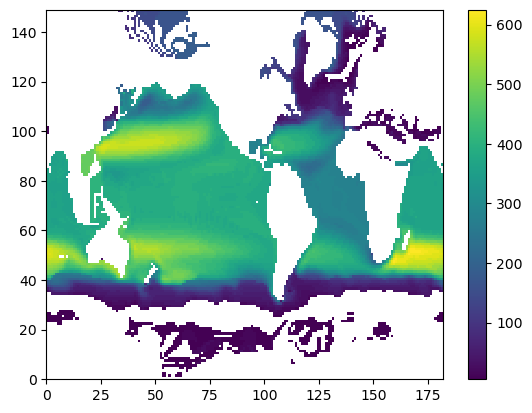

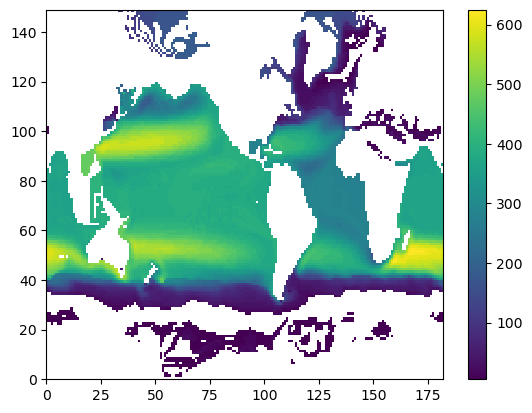

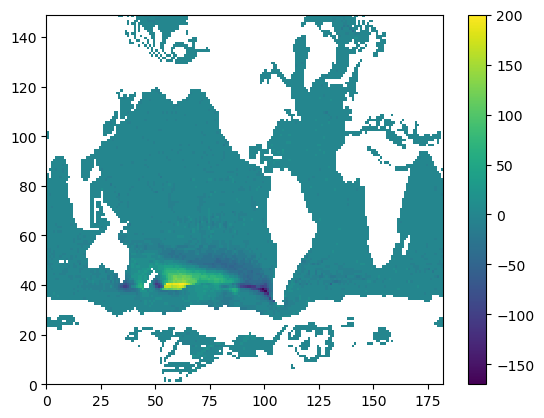

In [14]:
plt.figure()
plt.pcolormesh(depSEp_Usamw.mean(dim='month').mean(dim='depth', skipna=True))
plt.colorbar()
plt.figure()
plt.pcolormesh(depSWp_Usamw.mean(dim='month').mean(dim='depth', skipna=True))
plt.colorbar()
plt.figure()
plt.pcolormesh(depSEp_Usamw.mean(dim='month').mean(dim='depth', skipna=True) - depSWp_Usamw.mean(dim='month').mean(dim='depth', skipna=True))
plt.colorbar()

## Calculate the changes

In [15]:
%%time

dtem_samw = tem_samw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - tem_samw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
ddep_samw = dep_samw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - dep_samw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dsal_samw = sal_samw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - sal_samw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dage_samw = age_samw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - age_samw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
do2_samw = o2_samw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - o2_samw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
ddic_samw = dic_samw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - dic_samw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dno3_samw = no3_samw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - no3_samw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dtem_Usamw = tem_Usamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - tem_Usamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
ddep_Usamw = dep_Usamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - dep_Usamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dsal_Usamw = sal_Usamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - sal_Usamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dage_Usamw = age_Usamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - age_Usamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
do2_Usamw = o2_Usamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - o2_Usamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
ddic_Usamw = dic_Usamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - dic_Usamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dno3_Usamw = no3_Usamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - no3_Usamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dtem_Csamw = tem_Csamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - tem_Csamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
ddep_Csamw = dep_Csamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - dep_Csamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dsal_Csamw = sal_Csamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - sal_Csamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dage_Csamw = age_Csamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - age_Csamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
do2_Csamw = o2_Csamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - o2_Csamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
ddic_Csamw = dic_Csamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - dic_Csamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dno3_Csamw = no3_Csamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - no3_Csamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dtem_Lsamw = tem_Lsamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - tem_Lsamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
ddep_Lsamw = dep_Lsamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - dep_Lsamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dsal_Lsamw = sal_Lsamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - sal_Lsamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dage_Lsamw = age_Lsamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - age_Lsamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
do2_Lsamw = o2_Lsamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - o2_Lsamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
ddic_Lsamw = dic_Lsamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - dic_Lsamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)
dno3_Lsamw = no3_Lsamw.isel(year=slice(-20,-1)).mean(dim=['year', 'depth'], skipna=True) - no3_Lsamw.isel(year=slice(0,20)).mean(dim=['year', 'depth'], skipna=True)

dtemP_samw = temSEp_samw.mean(dim='depth', skipna=True) - temSWp_samw.mean(dim='depth', skipna=True)
ddepP_samw = depSEp_samw.mean(dim='depth', skipna=True) - depSWp_samw.mean(dim='depth', skipna=True)
dsalP_samw = salSEp_samw.mean(dim='depth', skipna=True) - salSWp_samw.mean(dim='depth', skipna=True)
dageP_samw = ageSEp_samw.mean(dim='depth', skipna=True) - ageSWp_samw.mean(dim='depth', skipna=True)
do2P_samw = o2SEp_samw.mean(dim='depth', skipna=True) - o2SWp_samw.mean(dim='depth', skipna=True)
ddicP_samw = dicSEp_samw.mean(dim='depth', skipna=True) - dicSWp_samw.mean(dim='depth', skipna=True)
dno3P_samw = no3SEp_samw.mean(dim='depth', skipna=True) - no3SWp_samw.mean(dim='depth', skipna=True)
dtemP_Usamw = temSEp_Usamw.mean(dim='depth', skipna=True) - temSWp_Usamw.mean(dim='depth', skipna=True)
ddepP_Usamw = depSEp_Usamw.mean(dim='depth', skipna=True) - depSWp_Usamw.mean(dim='depth', skipna=True)
dsalP_Usamw = salSEp_Usamw.mean(dim='depth', skipna=True) - salSWp_Usamw.mean(dim='depth', skipna=True)
dageP_Usamw = ageSEp_Usamw.mean(dim='depth', skipna=True) - ageSWp_Usamw.mean(dim='depth', skipna=True)
do2P_Usamw = o2SEp_Usamw.mean(dim='depth', skipna=True) - o2SWp_Usamw.mean(dim='depth', skipna=True)
ddicP_Usamw = dicSEp_Usamw.mean(dim='depth', skipna=True) - dicSWp_Usamw.mean(dim='depth', skipna=True)
dno3P_Usamw = no3SEp_Usamw.mean(dim='depth', skipna=True) - no3SWp_Usamw.mean(dim='depth', skipna=True)
dtemP_Csamw = temSEp_Csamw.mean(dim='depth', skipna=True) - temSWp_Csamw.mean(dim='depth', skipna=True)
ddepP_Csamw = depSEp_Csamw.mean(dim='depth', skipna=True) - depSWp_Csamw.mean(dim='depth', skipna=True)
dsalP_Csamw = salSEp_Csamw.mean(dim='depth', skipna=True) - salSWp_Csamw.mean(dim='depth', skipna=True)
dageP_Csamw = ageSEp_Csamw.mean(dim='depth', skipna=True) - ageSWp_Csamw.mean(dim='depth', skipna=True)
do2P_Csamw = o2SEp_Csamw.mean(dim='depth', skipna=True) - o2SWp_Csamw.mean(dim='depth', skipna=True)
ddicP_Csamw = dicSEp_Csamw.mean(dim='depth', skipna=True) - dicSWp_Csamw.mean(dim='depth', skipna=True)
dno3P_Csamw = no3SEp_Csamw.mean(dim='depth', skipna=True) - no3SWp_Csamw.mean(dim='depth', skipna=True)
dtemP_Lsamw = temSEp_Lsamw.mean(dim='depth', skipna=True) - temSWp_Lsamw.mean(dim='depth', skipna=True)
ddepP_Lsamw = depSEp_Lsamw.mean(dim='depth', skipna=True) - depSWp_Lsamw.mean(dim='depth', skipna=True)
dsalP_Lsamw = salSEp_Lsamw.mean(dim='depth', skipna=True) - salSWp_Lsamw.mean(dim='depth', skipna=True)
dageP_Lsamw = ageSEp_Lsamw.mean(dim='depth', skipna=True) - ageSWp_Lsamw.mean(dim='depth', skipna=True)
do2P_Lsamw = o2SEp_Lsamw.mean(dim='depth', skipna=True) - o2SWp_Lsamw.mean(dim='depth', skipna=True)
ddicP_Lsamw = dicSEp_Lsamw.mean(dim='depth', skipna=True) - dicSWp_Lsamw.mean(dim='depth', skipna=True)
dno3P_Lsamw = no3SEp_Lsamw.mean(dim='depth', skipna=True) - no3SWp_Lsamw.mean(dim='depth', skipna=True)

dtemI_samw = temSEi_samw.mean(dim='depth', skipna=True) - temSWi_samw.mean(dim='depth', skipna=True)
ddepI_samw = depSEi_samw.mean(dim='depth', skipna=True) - depSWi_samw.mean(dim='depth', skipna=True)
dsalI_samw = salSEi_samw.mean(dim='depth', skipna=True) - salSWi_samw.mean(dim='depth', skipna=True)
dageI_samw = ageSEi_samw.mean(dim='depth', skipna=True) - ageSWi_samw.mean(dim='depth', skipna=True)
do2I_samw = o2SEi_samw.mean(dim='depth', skipna=True) - o2SWi_samw.mean(dim='depth', skipna=True)
ddicI_samw = dicSEi_samw.mean(dim='depth', skipna=True) - dicSWi_samw.mean(dim='depth', skipna=True)
dno3I_samw = no3SEi_samw.mean(dim='depth', skipna=True) - no3SWi_samw.mean(dim='depth', skipna=True)
dtemI_Usamw = temSEi_Usamw.mean(dim='depth', skipna=True) - temSWi_Usamw.mean(dim='depth', skipna=True)
ddepI_Usamw = depSEi_Usamw.mean(dim='depth', skipna=True) - depSWi_Usamw.mean(dim='depth', skipna=True)
dsalI_Usamw = salSEi_Usamw.mean(dim='depth', skipna=True) - salSWi_Usamw.mean(dim='depth', skipna=True)
dageI_Usamw = ageSEi_Usamw.mean(dim='depth', skipna=True) - ageSWi_Usamw.mean(dim='depth', skipna=True)
do2I_Usamw = o2SEi_Usamw.mean(dim='depth', skipna=True) - o2SWi_Usamw.mean(dim='depth', skipna=True)
ddicI_Usamw = dicSEi_Usamw.mean(dim='depth', skipna=True) - dicSWi_Usamw.mean(dim='depth', skipna=True)
dno3I_Usamw = no3SEi_Usamw.mean(dim='depth', skipna=True) - no3SWi_Usamw.mean(dim='depth', skipna=True)
dtemI_Csamw = temSEi_Csamw.mean(dim='depth', skipna=True) - temSWi_Csamw.mean(dim='depth', skipna=True)
ddepI_Csamw = depSEi_Csamw.mean(dim='depth', skipna=True) - depSWi_Csamw.mean(dim='depth', skipna=True)
dsalI_Csamw = salSEi_Csamw.mean(dim='depth', skipna=True) - salSWi_Csamw.mean(dim='depth', skipna=True)
dageI_Csamw = ageSEi_Csamw.mean(dim='depth', skipna=True) - ageSWi_Csamw.mean(dim='depth', skipna=True)
do2I_Csamw = o2SEi_Csamw.mean(dim='depth', skipna=True) - o2SWi_Csamw.mean(dim='depth', skipna=True)
ddicI_Csamw = dicSEi_Csamw.mean(dim='depth', skipna=True) - dicSWi_Csamw.mean(dim='depth', skipna=True)
dno3I_Csamw = no3SEi_Csamw.mean(dim='depth', skipna=True) - no3SWi_Csamw.mean(dim='depth', skipna=True)
dtemI_Lsamw = temSEi_Lsamw.mean(dim='depth', skipna=True) - temSWi_Lsamw.mean(dim='depth', skipna=True)
ddepI_Lsamw = depSEi_Lsamw.mean(dim='depth', skipna=True) - depSWi_Lsamw.mean(dim='depth', skipna=True)
dsalI_Lsamw = salSEi_Lsamw.mean(dim='depth', skipna=True) - salSWi_Lsamw.mean(dim='depth', skipna=True)
dageI_Lsamw = ageSEi_Lsamw.mean(dim='depth', skipna=True) - ageSWi_Lsamw.mean(dim='depth', skipna=True)
do2I_Lsamw = o2SEi_Lsamw.mean(dim='depth', skipna=True) - o2SWi_Lsamw.mean(dim='depth', skipna=True)
ddicI_Lsamw = dicSEi_Lsamw.mean(dim='depth', skipna=True) - dicSWi_Lsamw.mean(dim='depth', skipna=True)
dno3I_Lsamw = no3SEi_Lsamw.mean(dim='depth', skipna=True) - no3SWi_Lsamw.mean(dim='depth', skipna=True)


CPU times: user 10 s, sys: 2.39 s, total: 12.4 s
Wall time: 12.5 s


CPU times: user 78.7 ms, sys: 995 μs, total: 79.7 ms
Wall time: 79.6 ms


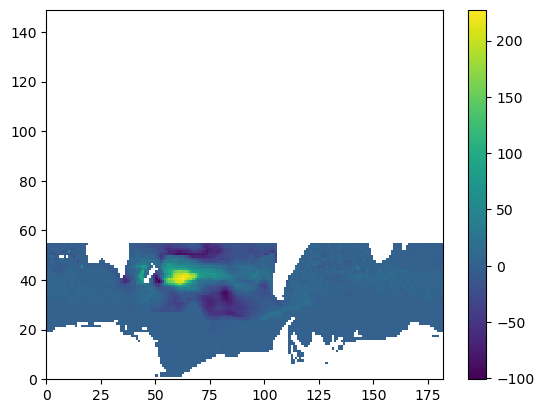

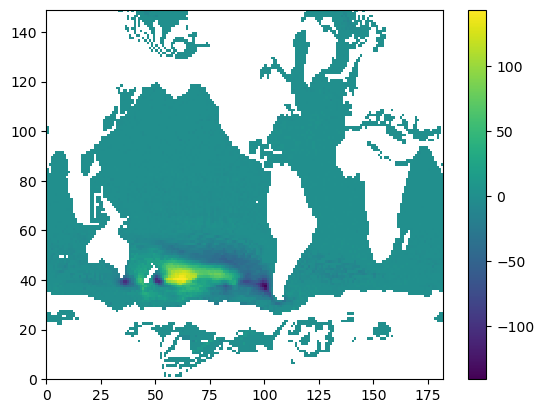

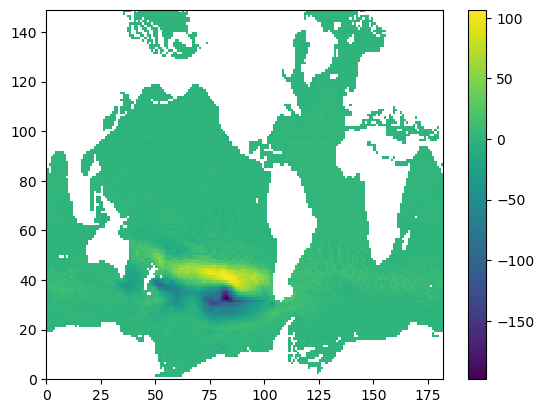

In [16]:
%%time

plt.figure()
plt.pcolormesh(ddepP_samw.mean(dim='month'))
plt.colorbar()

plt.figure()
plt.pcolormesh(ddepP_Usamw.mean(dim='month'))
plt.colorbar()

plt.figure()
plt.pcolormesh(ddepP_Lsamw.mean(dim='month'))
plt.colorbar()

## Regrid the datasets


In [20]:
%%time

ds_out = xe.util.grid_global(1,1)
'''
ds_samw = xr.Dataset(
    {'delta_tem_samw': ( ('month', 'y', 'x'), dtem_samw.values),
     'delta_dep_samw': ( ('month', 'y', 'x'), ddep_samw.values),
     'delta_sal_samw': ( ('month', 'y', 'x'), dsal_samw.values),
     'delta_age_samw': ( ('month', 'y', 'x'), dage_samw.values),
     'delta_o2_samw': ( ('month', 'y', 'x'), do2_samw.values),
     'delta_dic_samw': ( ('month', 'y', 'x'), ddic_samw.values),
     'delta_no3_samw': ( ('month', 'y', 'x'), dno3_samw.values),
     'delta_tem_pac_samw': ( ('month', 'y', 'x'), dtemP_samw.values),
     'delta_dep_pac_samw': ( ('month', 'y', 'x'), ddepP_samw.values),
     'delta_sal_pac_samw': ( ('month', 'y', 'x'), dsalP_samw.values),
     'delta_age_pac_samw': ( ('month', 'y', 'x'), dageP_samw.values),
     'delta_o2_pac_samw': ( ('month', 'y', 'x'), do2P_samw.values),
     'delta_dic_pac_samw': ( ('month', 'y', 'x'), ddicP_samw.values),
     'delta_no3_pac_samw': ( ('month', 'y', 'x'), dno3P_samw.values),
     'delta_tem_ind_samw': ( ('month', 'y', 'x'), dtemI_samw.values),
     'delta_dep_ind_samw': ( ('month', 'y', 'x'), ddepI_samw.values),
     'delta_sal_ind_samw': ( ('month', 'y', 'x'), dsalI_samw.values),
     'delta_age_ind_samw': ( ('month', 'y', 'x'), dageI_samw.values),
     'delta_o2_ind_samw': ( ('month', 'y', 'x'), do2I_samw.values),
     'delta_dic_ind_samw': ( ('month', 'y', 'x'), ddicI_samw.values),
     'delta_no3_ind_samw': ( ('month', 'y', 'x'), dno3I_samw.values),
    },
    coords={"lon": (['y','x'], lons.values),
            "lat": (['y','x'], lats.values),
            "month": (['month'], month),
            }
    )
regridder_samw = xe.Regridder(ds_samw, ds_out, 'bilinear', ignore_degenerate=True)
'''
'''
ds_Usamw = xr.Dataset(
    {'delta_tem_Usamw': ( ('month', 'y', 'x'), dtem_Usamw.values),
     'delta_dep_Usamw': ( ('month', 'y', 'x'), ddep_Usamw.values),
     'delta_sal_Usamw': ( ('month', 'y', 'x'), dsal_Usamw.values),
     'delta_age_Usamw': ( ('month', 'y', 'x'), dage_Usamw.values),
     'delta_o2_Usamw': ( ('month', 'y', 'x'), do2_Usamw.values),
     'delta_dic_Usamw': ( ('month', 'y', 'x'), ddic_Usamw.values),
     'delta_no3_Usamw': ( ('month', 'y', 'x'), dno3_Usamw.values),
     'delta_tem_pac_Usamw': ( ('month', 'y', 'x'), dtemP_Usamw.values),
     'delta_dep_pac_Usamw': ( ('month', 'y', 'x'), ddepP_Usamw.values),
     'delta_sal_pac_Usamw': ( ('month', 'y', 'x'), dsalP_Usamw.values),
     'delta_age_pac_Usamw': ( ('month', 'y', 'x'), dageP_Usamw.values),
     'delta_o2_pac_Usamw': ( ('month', 'y', 'x'), do2P_Usamw.values),
     'delta_dic_pac_Usamw': ( ('month', 'y', 'x'), ddicP_Usamw.values),
     'delta_no3_pac_Usamw': ( ('month', 'y', 'x'), dno3P_Usamw.values),
     'delta_tem_ind_Usamw': ( ('month', 'y', 'x'), dtemI_Usamw.values),
     'delta_dep_ind_Usamw': ( ('month', 'y', 'x'), ddepI_Usamw.values),
     'delta_sal_ind_Usamw': ( ('month', 'y', 'x'), dsalI_Usamw.values),
     'delta_age_ind_Usamw': ( ('month', 'y', 'x'), dageI_Usamw.values),
     'delta_o2_ind_Usamw': ( ('month', 'y', 'x'), do2I_Usamw.values),
     'delta_dic_ind_Usamw': ( ('month', 'y', 'x'), ddicI_Usamw.values),
     'delta_no3_ind_Usamw': ( ('month', 'y', 'x'), dno3I_Usamw.values),
     },
    coords={"lon": (['y','x'], lons.values),
            "lat": (['y','x'], lats.values),
            "month": (['month'], month),
            }
    )
regridder_Usamw = xe.Regridder(ds_Usamw, ds_out, 'bilinear', ignore_degenerate=True)

'''
ds_Lsamw = xr.Dataset(
    {'delta_tem_Lsamw': ( ('month', 'y', 'x'), dtem_Lsamw.values),
     'delta_dep_Lsamw': ( ('month', 'y', 'x'), ddep_Lsamw.values),
     'delta_sal_Lsamw': ( ('month', 'y', 'x'), dsal_Lsamw.values),
     'delta_age_Lsamw': ( ('month', 'y', 'x'), dage_Lsamw.values),
     'delta_o2_Lsamw': ( ('month', 'y', 'x'), do2_Lsamw.values),
     'delta_dic_Lsamw': ( ('month', 'y', 'x'), ddic_Lsamw.values),
     'delta_no3_Lsamw': ( ('month', 'y', 'x'), dno3_Lsamw.values),
     'delta_tem_pac_Lsamw': ( ('month', 'y', 'x'), dtemP_Lsamw.values),
     'delta_dep_pac_Lsamw': ( ('month', 'y', 'x'), ddepP_Lsamw.values),
     'delta_sal_pac_Lsamw': ( ('month', 'y', 'x'), dsalP_Lsamw.values),
     'delta_age_pac_Lsamw': ( ('month', 'y', 'x'), dageP_Lsamw.values),
     'delta_o2_pac_Lsamw': ( ('month', 'y', 'x'), do2P_Lsamw.values),
     'delta_dic_pac_Lsamw': ( ('month', 'y', 'x'), ddicP_Lsamw.values),
     'delta_no3_pac_Lsamw': ( ('month', 'y', 'x'), dno3P_Lsamw.values),
     'delta_tem_ind_Lsamw': ( ('month', 'y', 'x'), dtemI_Lsamw.values),
     'delta_dep_ind_Lsamw': ( ('month', 'y', 'x'), ddepI_Lsamw.values),
     'delta_sal_ind_Lsamw': ( ('month', 'y', 'x'), dsalI_Lsamw.values),
     'delta_age_ind_Lsamw': ( ('month', 'y', 'x'), dageI_Lsamw.values),
     'delta_o2_ind_Lsamw': ( ('month', 'y', 'x'), do2I_Lsamw.values),
     'delta_dic_ind_Lsamw': ( ('month', 'y', 'x'), ddicI_Lsamw.values),
     'delta_no3_ind_Lsamw': ( ('month', 'y', 'x'), dno3I_Lsamw.values),
     },
    coords={"lon": (['y','x'], lons.values),
            "lat": (['y','x'], lats.values),
            "month": (['month'], month),
            }
    )
regridder_Lsamw = xe.Regridder(ds_Lsamw, ds_out, 'bilinear', ignore_degenerate=True)


CPU times: user 4h 13min 52s, sys: 2h 23min 53s, total: 6h 37min 46s
Wall time: 4h 13min 1s


In [19]:
### save the dataset as is so I never have to wait this long again
#ds_Usamw.to_netcdf(wrkdir + "/JRA55_pic_delta_properties_Usamw.nc")
#ds_samw.to_netcdf(wrkdir + "/JRA55_pic_delta_properties_samw.nc")
ds_Lsamw.to_netcdf(wrkdir + "/JRA55_pic_delta_properties_Lsamw.nc")


In [24]:
%%time

print("Regridding")
delta_tem_samw_reg = regridder_samw(ds_samw['delta_tem_samw'])
delta_dep_samw_reg = regridder_samw(ds_samw['delta_dep_samw'])
delta_sal_samw_reg = regridder_samw(ds_samw['delta_sal_samw'])
delta_age_samw_reg = regridder_samw(ds_samw['delta_age_samw'])
delta_o2_samw_reg = regridder_samw(ds_samw['delta_o2_samw'])
delta_dic_samw_reg = regridder_samw(ds_samw['delta_dic_samw'])
delta_no3_samw_reg = regridder_samw(ds_samw['delta_no3_samw'])
'''
delta_tem_Usamw_reg = regridder_Usamw(ds_Usamw['delta_tem_Usamw'])
delta_sal_Usamw_reg = regridder_Usamw(ds_Usamw['delta_sal_Usamw'])
delta_age_Usamw_reg = regridder_Usamw(ds_Usamw['delta_age_Usamw'])
delta_o2_Usamw_reg = regridder_Usamw(ds_Usamw['delta_o2_Usamw'])
delta_dic_Usamw_reg = regridder_Usamw(ds_Usamw['delta_dic_Usamw'])
delta_no3_Usamw_reg = regridder_Usamw(ds_Usamw['delta_no3_Usamw'])
delta_tem_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_tem_pac_Usamw'])
delta_sal_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_sal_pac_Usamw'])
delta_age_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_age_pac_Usamw'])
delta_o2_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_o2_pac_Usamw'])
delta_dic_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_dic_pac_Usamw'])
delta_no3_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_no3_pac_Usamw'])
delta_tem_ind_Usamw_reg = regridder_Usamw(ds_Usamw['delta_tem_ind_Usamw'])
delta_sal_ind_Usamw_reg = regridder_Usamw(ds_Usamw['delta_sal_ind_Usamw'])
delta_age_ind_Usamw_reg = regridder_Usamw(ds_Usamw['delta_age_ind_Usamw'])
delta_o2_ind_Usamw_reg = regridder_Usamw(ds_Usamw['delta_o2_ind_Usamw'])
delta_dic_ind_Usamw_reg = regridder_Usamw(ds_Usamw['delta_dic_ind_Usamw'])
delta_no3_ind_Usamw_reg = regridder_Usamw(ds_Usamw['delta_no3_ind_Usamw'])
'''




Regridding
CPU times: user 554 ms, sys: 9.29 ms, total: 564 ms
Wall time: 572 ms


"\ndelta_tem_Usamw_reg = regridder_Usamw(ds_Usamw['delta_tem_Usamw'])\ndelta_sal_Usamw_reg = regridder_Usamw(ds_Usamw['delta_sal_Usamw'])\ndelta_age_Usamw_reg = regridder_Usamw(ds_Usamw['delta_age_Usamw'])\ndelta_o2_Usamw_reg = regridder_Usamw(ds_Usamw['delta_o2_Usamw'])\ndelta_dic_Usamw_reg = regridder_Usamw(ds_Usamw['delta_dic_Usamw'])\ndelta_no3_Usamw_reg = regridder_Usamw(ds_Usamw['delta_no3_Usamw'])\ndelta_tem_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_tem_pac_Usamw'])\ndelta_sal_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_sal_pac_Usamw'])\ndelta_age_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_age_pac_Usamw'])\ndelta_o2_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_o2_pac_Usamw'])\ndelta_dic_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_dic_pac_Usamw'])\ndelta_no3_pac_Usamw_reg = regridder_Usamw(ds_Usamw['delta_no3_pac_Usamw'])\ndelta_tem_ind_Usamw_reg = regridder_Usamw(ds_Usamw['delta_tem_ind_Usamw'])\ndelta_sal_ind_Usamw_reg = regridder_Usamw(ds_Usamw['delta_sal

## wrap longitudes (SAMW)

In [27]:
delta_tem_samw_reg = xr.DataArray(
    delta_tem_samw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_dep_samw_reg = xr.DataArray(
    delta_dep_samw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_sal_samw_reg = xr.DataArray(
    delta_sal_samw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_age_samw_reg = xr.DataArray(
    delta_age_samw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_o2_samw_reg = xr.DataArray(
    delta_o2_samw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_dic_samw_reg = xr.DataArray(
    delta_dic_samw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_no3_samw_reg = xr.DataArray(
    delta_no3_samw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )

delta_tem_samw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_tem_samw_reg, coord=delta_dic_samw_reg.coords['lon'])
delta_dep_samw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_dep_samw_reg, coord=delta_dic_samw_reg.coords['lon'])
delta_sal_samw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_sal_samw_reg, coord=delta_dic_samw_reg.coords['lon'])
delta_age_samw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_age_samw_reg, coord=delta_dic_samw_reg.coords['lon'])
delta_o2_samw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_o2_samw_reg, coord=delta_dic_samw_reg.coords['lon'])
delta_dic_samw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_dic_samw_reg, coord=delta_dic_samw_reg.coords['lon'])
delta_no3_samw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_no3_samw_reg, coord=delta_dic_samw_reg.coords['lon'])




## wrap longitudes (U SAMW)

In [23]:
delta_tem_Usamw_reg = xr.DataArray(
    delta_tem_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_sal_Usamw_reg = xr.DataArray(
    delta_sal_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_age_Usamw_reg = xr.DataArray(
    delta_age_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_o2_Usamw_reg = xr.DataArray(
    delta_o2_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_dic_Usamw_reg = xr.DataArray(
    delta_dic_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_no3_Usamw_reg = xr.DataArray(
    delta_no3_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )

delta_tem_pac_Usamw_reg = xr.DataArray(
    delta_tem_pac_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_sal_pac_Usamw_reg = xr.DataArray(
    delta_sal_pac_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_age_pac_Usamw_reg = xr.DataArray(
    delta_age_pac_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_o2_pac_Usamw_reg = xr.DataArray(
    delta_o2_pac_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_dic_pac_Usamw_reg = xr.DataArray(
    delta_dic_pac_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_no3_pac_Usamw_reg = xr.DataArray(
    delta_no3_pac_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )

delta_tem_ind_Usamw_reg = xr.DataArray(
    delta_tem_ind_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_sal_ind_Usamw_reg = xr.DataArray(
    delta_sal_ind_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_age_ind_Usamw_reg = xr.DataArray(
    delta_age_ind_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_o2_ind_Usamw_reg = xr.DataArray(
    delta_o2_ind_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_dic_ind_Usamw_reg = xr.DataArray(
    delta_dic_ind_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )
delta_no3_ind_Usamw_reg = xr.DataArray(
    delta_no3_ind_Usamw_reg,
    dims=("month", "y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            "month": (['month'], month),
            }
    )


delta_tem_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_tem_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_sal_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_sal_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_age_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_age_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_o2_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_o2_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_dic_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_dic_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_no3_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_no3_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])

delta_tem_pac_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_tem_pac_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_sal_pac_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_sal_pac_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_age_pac_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_age_pac_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_o2_pac_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_o2_pac_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_dic_pac_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_dic_pac_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_no3_pac_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_no3_pac_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])

delta_tem_ind_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_tem_ind_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_sal_ind_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_sal_ind_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_age_ind_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_age_ind_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_o2_ind_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_o2_ind_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_dic_ind_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_dic_ind_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])
delta_no3_ind_Usamw_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(delta_no3_ind_Usamw_reg, coord=delta_dic_Usamw_reg.coords['lon'])




## Figure 4

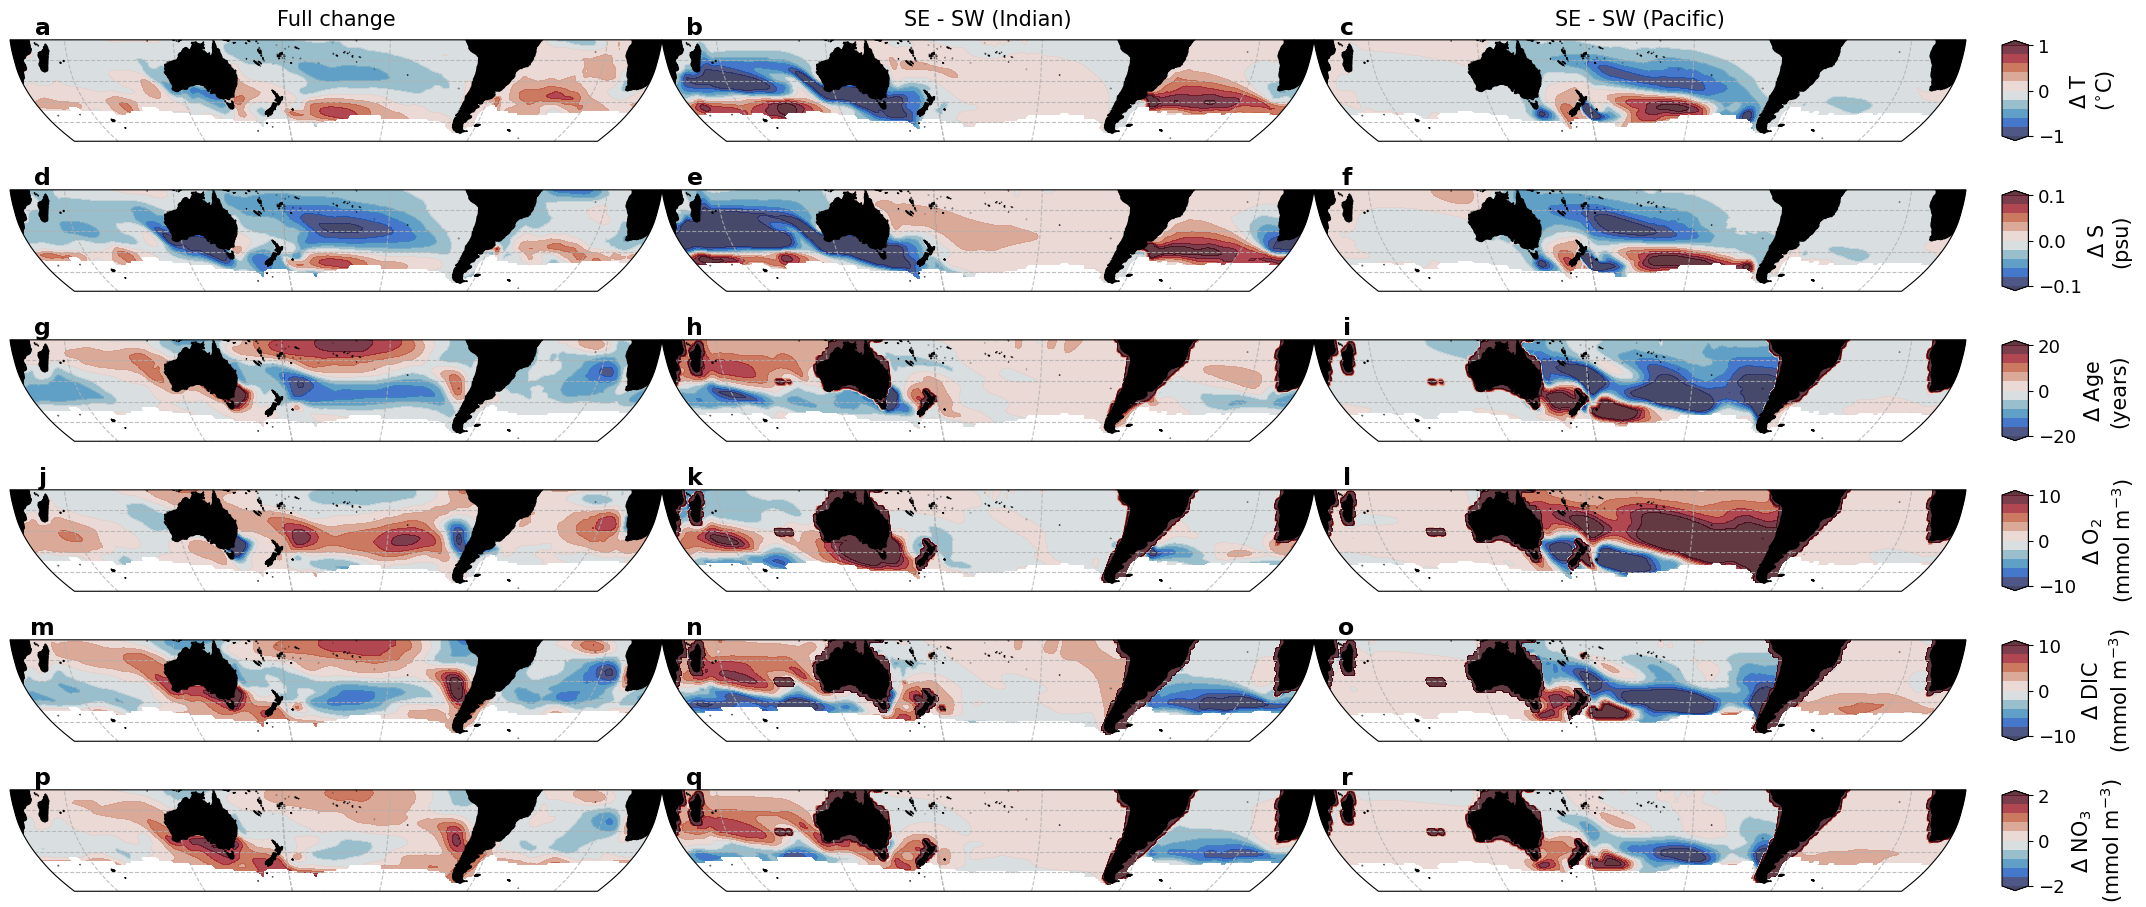

In [30]:

proj = ccrs.Robinson(central_longitude=210)

levs1 = np.arange(-10,11,2)*0.1 # T
levs2 = np.arange(-10,11,2)*0.01 # S
levs3 = np.arange(-20,21,4) # Age
levs4 = np.arange(-10,11,2) # O2
levs5 = np.arange(-10,11,2) # DIC
levs6 = np.arange(-20,21,4)*0.1 # NO3

colmap = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15

fig = plt.figure(figsize=(24,10), facecolor='w')
gs = GridSpec(6,3)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[0,2], projection=proj)
ax4 = plt.subplot(gs[1,0], projection=proj)
ax5 = plt.subplot(gs[1,1], projection=proj)
ax6 = plt.subplot(gs[1,2], projection=proj)
ax7 = plt.subplot(gs[2,0], projection=proj)
ax8 = plt.subplot(gs[2,1], projection=proj)
ax9 = plt.subplot(gs[2,2], projection=proj)
ax10 = plt.subplot(gs[3,0], projection=proj)
ax11 = plt.subplot(gs[3,1], projection=proj)
ax12 = plt.subplot(gs[3,2], projection=proj)
ax13 = plt.subplot(gs[4,0], projection=proj)
ax14 = plt.subplot(gs[4,1], projection=proj)
ax15 = plt.subplot(gs[4,2], projection=proj)
ax16 = plt.subplot(gs[5,0], projection=proj)
ax17 = plt.subplot(gs[5,1], projection=proj)
ax18 = plt.subplot(gs[5,2], projection=proj)

ax1.add_feature(cfeature.LAND, zorder=3, color='k')
ax2.add_feature(cfeature.LAND, zorder=3, color='k')
ax3.add_feature(cfeature.LAND, zorder=3, color='k')
ax4.add_feature(cfeature.LAND, zorder=3, color='k')
ax5.add_feature(cfeature.LAND, zorder=3, color='k')
ax6.add_feature(cfeature.LAND, zorder=3, color='k')
ax7.add_feature(cfeature.LAND, zorder=3, color='k')
ax8.add_feature(cfeature.LAND, zorder=3, color='k')
ax9.add_feature(cfeature.LAND, zorder=3, color='k')
ax10.add_feature(cfeature.LAND, zorder=3, color='k')
ax11.add_feature(cfeature.LAND, zorder=3, color='k')
ax12.add_feature(cfeature.LAND, zorder=3, color='k')
ax13.add_feature(cfeature.LAND, zorder=3, color='k')
ax14.add_feature(cfeature.LAND, zorder=3, color='k')
ax15.add_feature(cfeature.LAND, zorder=3, color='k')
ax16.add_feature(cfeature.LAND, zorder=3, color='k')
ax17.add_feature(cfeature.LAND, zorder=3, color='k')
ax18.add_feature(cfeature.LAND, zorder=3, color='k')
ax1.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax2.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax3.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax4.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax5.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax6.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax7.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax8.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax9.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax10.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax11.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax12.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax13.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax14.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax15.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax16.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax17.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())
ax18.set_extent([-180,180,-60,-10], crs=ccrs.PlateCarree())

p1 = ax1.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_tem_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs1, cmap=colmap, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
p2 = ax2.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_tem_ind_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs1, cmap=colmap, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')
p3 = ax3.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_tem_pac_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs1, cmap=colmap, vmin=np.min(levs1), vmax=np.max(levs1), extend='both')

p4 = ax4.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_sal_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs2, cmap=colmap, vmin=np.min(levs2), vmax=np.max(levs2), extend='both')
p5 = ax5.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_sal_ind_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs2, cmap=colmap, vmin=np.min(levs2), vmax=np.max(levs2), extend='both')
p6 = ax6.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_sal_pac_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs2, cmap=colmap, vmin=np.min(levs2), vmax=np.max(levs2), extend='both')

p7 = ax7.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_age_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs3, cmap=colmap, vmin=np.min(levs3), vmax=np.max(levs3), extend='both')
p8 = ax8.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_age_ind_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs3, cmap=colmap, vmin=np.min(levs3), vmax=np.max(levs3), extend='both')
p9 = ax9.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_age_pac_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs3, cmap=colmap, vmin=np.min(levs3), vmax=np.max(levs3), extend='both')

p10 = ax10.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_o2_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs4, cmap=colmap, vmin=np.min(levs4), vmax=np.max(levs4), extend='both')
p11 = ax11.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_o2_ind_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs4, cmap=colmap, vmin=np.min(levs4), vmax=np.max(levs4), extend='both')
p12 = ax12.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_o2_pac_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs4, cmap=colmap, vmin=np.min(levs4), vmax=np.max(levs4), extend='both')

p13 = ax13.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_dic_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs5, cmap=colmap, vmin=np.min(levs5), vmax=np.max(levs5), extend='both')
p14 = ax14.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_dic_ind_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs5, cmap=colmap, vmin=np.min(levs5), vmax=np.max(levs5), extend='both')
p15 = ax15.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_dic_pac_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs5, cmap=colmap, vmin=np.min(levs5), vmax=np.max(levs5), extend='both')

p16 = ax16.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_no3_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs6, cmap=colmap, vmin=np.min(levs6), vmax=np.max(levs6), extend='both')
p17 = ax17.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_no3_ind_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs6, cmap=colmap, vmin=np.min(levs6), vmax=np.max(levs6), extend='both')
p18 = ax18.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), np.mean(delta_no3_pac_Usamw_wrapped, axis=0), transform=ccrs.PlateCarree(), levels=levs6, cmap=colmap, vmin=np.min(levs6), vmax=np.max(levs6), extend='both')

plt.subplots_adjust(left=0.05, right=0.865, top=0.95, bottom=0.05, hspace=0.0, wspace=0.0)


xx = 0.05; yy = 1.12
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax10.transAxes)
plt.text(xx,yy,'k', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax11.transAxes)
plt.text(xx,yy,'l', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax12.transAxes)
plt.text(xx,yy,'m', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax13.transAxes)
plt.text(xx,yy,'n', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax14.transAxes)
plt.text(xx,yy,'o', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax15.transAxes)
plt.text(xx,yy,'p', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax16.transAxes)
plt.text(xx,yy,'q', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax17.transAxes)
plt.text(xx,yy,'r', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax18.transAxes)

xx = 0.5; yy = 1.2
plt.text(xx,yy,'Full change', fontsize=fslab, va='center', ha='center', transform=ax1.transAxes, rotation=0)
plt.text(xx,yy,'SE - SW (Indian)', fontsize=fslab, va='center', ha='center', transform=ax2.transAxes, rotation=0)
plt.text(xx,yy,'SE - SW (Pacific)', fontsize=fslab, va='center', ha='center', transform=ax3.transAxes, rotation=0)

cbax1 = fig.add_axes([0.88,0.825,0.011,0.1])
cbax4 = fig.add_axes([0.88,0.675,0.011,0.1])
cbax7 = fig.add_axes([0.88,0.525,0.011,0.1])
cbax10 = fig.add_axes([0.88,0.375,0.011,0.1])
cbax13 = fig.add_axes([0.88,0.225,0.011,0.1])
cbax16 = fig.add_axes([0.88,0.075,0.011,0.1])

cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5]) 
cbar4 = plt.colorbar(p4, cax=cbax4, orientation='vertical', ticks=levs2[::5]) 
cbar7 = plt.colorbar(p7, cax=cbax7, orientation='vertical', ticks=levs3[::5])
cbar10 = plt.colorbar(p10, cax=cbax10, orientation='vertical', ticks=levs4[::5])
cbar13 = plt.colorbar(p13, cax=cbax13, orientation='vertical', ticks=levs5[::5])
cbar16 = plt.colorbar(p16, cax=cbax16, orientation='vertical', ticks=levs6[::5])

cbar1.ax.tick_params(labelsize=fstic)
cbar4.ax.tick_params(labelsize=fstic)
cbar7.ax.tick_params(labelsize=fstic)
cbar10.ax.tick_params(labelsize=fstic)
cbar13.ax.tick_params(labelsize=fstic)
cbar16.ax.tick_params(labelsize=fstic)

cbar1.ax.set_ylabel('$\Delta$ T\n($^{\circ}$C)', fontsize=fslab)
cbar4.ax.set_ylabel('$\Delta$ S\n(psu)', fontsize=fslab)
cbar7.ax.set_ylabel('$\Delta$ Age\n(years)', fontsize=fslab)
cbar10.ax.set_ylabel('$\Delta$ O$_2$\n(mmol m$^{-3}$)', fontsize=fslab)
cbar13.ax.set_ylabel('$\Delta$ DIC\n(mmol m$^{-3}$)', fontsize=fslab)
cbar16.ax.set_ylabel('$\Delta$ NO$_3$\n(mmol m$^{-3}$)', fontsize=fslab)

ax1.gridlines(linestyle='--', alpha=0.8)
ax2.gridlines(linestyle='--', alpha=0.8)
ax3.gridlines(linestyle='--', alpha=0.8)
ax4.gridlines(linestyle='--', alpha=0.8)
ax5.gridlines(linestyle='--', alpha=0.8)
ax6.gridlines(linestyle='--', alpha=0.8)
ax7.gridlines(linestyle='--', alpha=0.8)
ax8.gridlines(linestyle='--', alpha=0.8)
ax9.gridlines(linestyle='--', alpha=0.8)
ax10.gridlines(linestyle='--', alpha=0.8)
ax11.gridlines(linestyle='--', alpha=0.8)
ax12.gridlines(linestyle='--', alpha=0.8)
ax13.gridlines(linestyle='--', alpha=0.8)
ax14.gridlines(linestyle='--', alpha=0.8)
ax15.gridlines(linestyle='--', alpha=0.8)
ax16.gridlines(linestyle='--', alpha=0.8)
ax17.gridlines(linestyle='--', alpha=0.8)
ax18.gridlines(linestyle='--', alpha=0.8)


In [32]:
fig.savefig('/home/pbuchanan/analysis_samw/fig-pacemakerexps_Usamw_changes.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-pacemakerexps_Usamw_changes.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-pacemakerexps_Usamw_changes_trans.png', dpi=300, bbox_inches='tight', transparent=True)


## do the correlations in SAMW changes between start-end hindcast and pacemaker runs

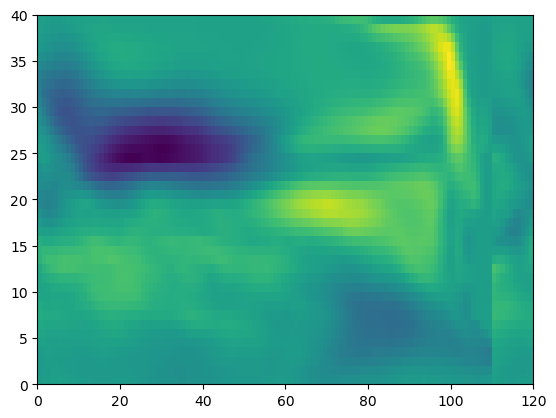

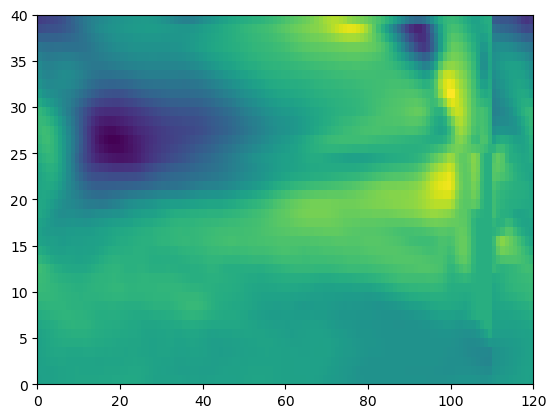

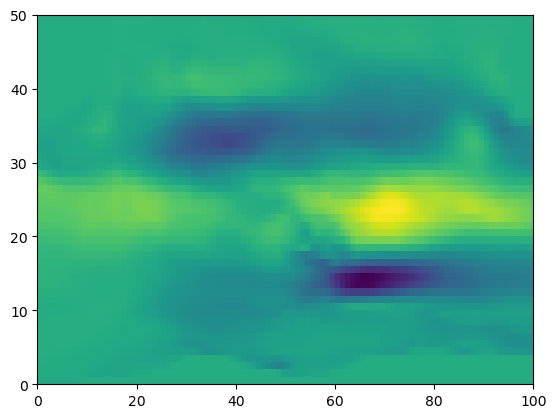

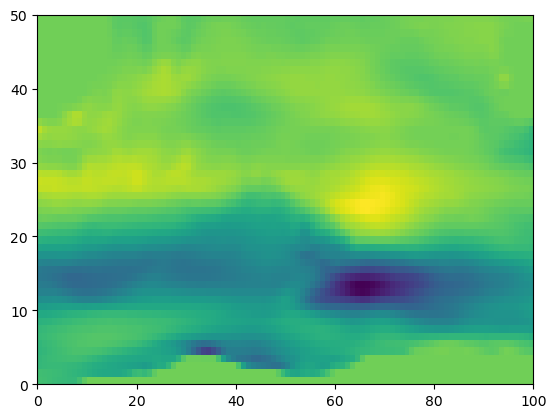

In [82]:
# get changes
dic_hind = (delta_dic_reg)
dicPac_pace = (SEPac_dic_reg - SWPac_dic_reg)
dicInd_pace = (SEInd_dic_reg - SWInd_dic_reg)
flx_hind = (delta_cflx_reg)
flxPac_pace = (SEPac_cflx_reg - SWPac_cflx_reg)
flxInd_pace = (SEInd_cflx_reg - SWInd_cflx_reg)
npp_hind = (delta_npp_reg)
nppPac_pace = (SEPac_npp_reg - SWPac_npp_reg)
nppInd_pace = (SEInd_npp_reg - SWInd_npp_reg)

lons = dic_hind.coords['lon'] 
lats = dic_hind.coords['lat'] 

# cut the areas
dicPac_hind = (dic_hind.where(lons < -70, other=0.0) + dic_hind.where(lons > 170.0, other=0.0)).where((lats < -20.0) & (lats > -60.0), other=0.0)
dicInd_hind = dic_hind.where((lons < 120.0) & (lons > 20.0) & (lats < -20.0) & (lats > -70.0), other=0.0)
dicPac_pace = (dicPac_pace.where(lons < -70.0, other=0.0) + dicPac_pace.where(lons > 170.0, other=0.0)).where((lats < -20.0) & (lats > -60.0), other=0.0)
dicInd_pace = dicInd_pace.where((lons < 120.0) & (lons > 20.0) & (lats < -20.0) & (lats > -70.0), other=0.0)

flxPac_hind = (flx_hind.where(lons < -70, other=0.0) + flx_hind.where(lons > 170.0, other=0.0)).where((lats < -20.0) & (lats > -60.0), other=0.0)
flxInd_hind = flx_hind.where((lons < 120.0) & (lons > 20.0) & (lats < -20.0) & (lats > -70.0), other=0.0)
flxPac_pace = (flxPac_pace.where(lons < -70.0, other=0.0) + flxPac_pace.where(lons > 170.0, other=0.0)).where((lats < -20.0) & (lats > -60.0), other=0.0)
flxInd_pace = flxInd_pace.where((lons < 120.0) & (lons > 20.0) & (lats < -20.0) & (lats > -70.0), other=0.0)

nppPac_hind = (npp_hind.where(lons < -70, other=0.0) + npp_hind.where(lons > 170.0, other=0.0)).where((lats < -20.0) & (lats > -60.0), other=0.0)
nppInd_hind = npp_hind.where((lons < 120.0) & (lons > 20.0) & (lats < -20.0) & (lats > -70.0), other=0.0)
nppPac_pace = (nppPac_pace.where(lons < -70.0, other=0.0) + nppPac_pace.where(lons > 170.0, other=0.0)).where((lats < -20.0) & (lats > -60.0), other=0.0)
nppInd_pace = nppInd_pace.where((lons < 120.0) & (lons > 20.0) & (lats < -20.0) & (lats > -70.0), other=0.0)


# drop the regions outside our area of interest
dicPac_hind = dicPac_hind.where(dicPac_hind != 0.0, drop=True).fillna(0.0)
dicInd_hind = dicInd_hind.where(dicInd_hind != 0.0, drop=True).fillna(0.0)
dicPac_pace = dicPac_pace.where(dicPac_pace != 0.0, drop=True).fillna(0.0)
dicInd_pace = dicInd_pace.where(dicInd_pace != 0.0, drop=True).fillna(0.0)

flxPac_hind = flxPac_hind.where(flxPac_hind != 0.0, drop=True).fillna(0.0)
flxInd_hind = flxInd_hind.where(flxInd_hind != 0.0, drop=True).fillna(0.0)
flxPac_pace = flxPac_pace.where(flxPac_pace != 0.0, drop=True).fillna(0.0)
flxInd_pace = flxInd_pace.where(flxInd_pace != 0.0, drop=True).fillna(0.0)

nppPac_hind = nppPac_hind.where(nppPac_hind != 0.0, drop=True).fillna(0.0)
nppInd_hind = nppInd_hind.where(nppInd_hind != 0.0, drop=True).fillna(0.0)
nppPac_pace = nppPac_pace.where(nppPac_pace != 0.0, drop=True).fillna(0.0)
nppInd_pace = nppInd_pace.where(nppInd_pace != 0.0, drop=True).fillna(0.0)


# add back the zeros 
#dicPac_hind = dicPac_hind.fillna(0.0)
#dicInd_hind = dicInd_hind.fillna(0.0)
#dicPac_pace = dicPac_pace.fillna(0.0)
#dicInd_pace = dicInd_pace.fillna(0.0)

plt.figure()
plt.pcolormesh(nppPac_pace.mean(dim='month'))
plt.figure()
plt.pcolormesh(nppPac_hind.mean(dim='month'))

plt.figure()
plt.pcolormesh(flxInd_pace.mean(dim='month'))
plt.figure()
plt.pcolormesh(flxInd_hind.mean(dim='month'))


In [83]:

### perform the correlation computation
from scipy.stats import pearsonr

ntimes = 1000
### to avoid spatial autocorrelation, randomly select from the arrays
corr_dicPac = np.zeros(ntimes)
corr_dicInd = np.zeros(ntimes)
p_val_dicPac = np.zeros(ntimes)
p_val_dicInd = np.zeros(ntimes)
corr_flxPac = np.zeros(ntimes)
corr_flxInd = np.zeros(ntimes)
p_val_flxPac = np.zeros(ntimes)
p_val_flxInd = np.zeros(ntimes)
corr_nppPac = np.zeros(ntimes)
corr_nppInd = np.zeros(ntimes)
p_val_nppPac = np.zeros(ntimes)
p_val_nppInd = np.zeros(ntimes)

# Randomly select 1000 indices from the range of 5000
for ii in np.arange(ntimes):
    np.random.seed(ii)  # Optional: Set a seed for reproducibility
    i_dicPac = np.random.choice(len(dicPac_hind.values.flatten()), size=1000, replace=False)
    i_dicInd = np.random.choice(len(dicInd_hind.values.flatten()), size=1000, replace=False)
    i_flxPac = np.random.choice(len(flxPac_hind.values.flatten()), size=1000, replace=False)
    i_flxInd = np.random.choice(len(flxInd_hind.values.flatten()), size=1000, replace=False)
    i_nppPac = np.random.choice(len(nppPac_hind.values.flatten()), size=1000, replace=False)
    i_nppInd = np.random.choice(len(nppInd_hind.values.flatten()), size=1000, replace=False)

    dic_hindPac = dicPac_hind.values.flatten()[i_dicPac]
    dic_hindInd = dicInd_hind.values.flatten()[i_dicInd]
    dic_pacePac = dicPac_pace.values.flatten()[i_dicPac]
    dic_paceInd = dicInd_pace.values.flatten()[i_dicInd]

    flx_hindPac = flxPac_hind.values.flatten()[i_flxPac]
    flx_hindInd = flxInd_hind.values.flatten()[i_flxInd]
    flx_pacePac = flxPac_pace.values.flatten()[i_flxPac]
    flx_paceInd = flxInd_pace.values.flatten()[i_flxInd]

    npp_hindPac = nppPac_hind.values.flatten()[i_nppPac]
    npp_hindInd = nppInd_hind.values.flatten()[i_nppInd]
    npp_pacePac = nppPac_pace.values.flatten()[i_nppPac]
    npp_paceInd = nppInd_pace.values.flatten()[i_nppInd]
    
    corr_dicPac[ii], p_val_dicPac[ii] = pearsonr(dic_hindPac, dic_pacePac)
    corr_dicInd[ii], p_val_dicInd[ii] = pearsonr(dic_hindInd, dic_paceInd)

    corr_flxPac[ii], p_val_flxPac[ii] = pearsonr(flx_hindPac, flx_pacePac)
    corr_flxInd[ii], p_val_flxInd[ii] = pearsonr(flx_hindInd, flx_paceInd)

    corr_nppPac[ii], p_val_nppPac[ii] = pearsonr(npp_hindPac, npp_pacePac)
    corr_nppInd[ii], p_val_nppInd[ii] = pearsonr(npp_hindInd, npp_paceInd)


print("Mean correlation for $\Delta$DIC in Pacific and Indian", np.mean(corr_dicPac), np.mean(corr_dicInd))
print("Mean correlation for $\Delta$CO$_2$ flux in Pacific and Indian", np.mean(corr_flxPac), np.mean(corr_flxInd))
print("Mean correlation for $\Delta$NPP in Pacific and Indian", np.mean(corr_nppPac), np.mean(corr_nppInd))


Mean correlation for $\Delta$DIC in Pacific and Indian 0.6064626577496529 0.5069975254237652
Mean correlation for $\Delta$CO$_2$ flux in Pacific and Indian 0.2708287508487701 0.28120553348958494
Mean correlation for $\Delta$NPP in Pacific and Indian 0.5508712264299392 0.35994735454022886


{'whiskers': [<matplotlib.lines.Line2D at 0x1553d37d41c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1553d37d4700>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1553d37a3df0>,
 'medians': [<matplotlib.lines.Line2D at 0x1553d37d4c40>,
 'fliers': [<matplotlib.lines.Line2D at 0x1553d37d4ee0>,
 'means': []}

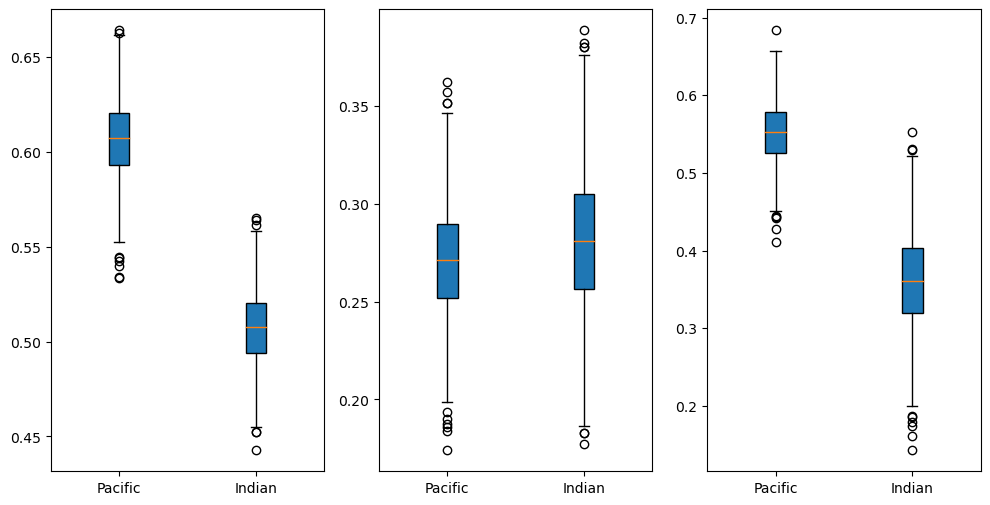

In [84]:

# Create a box and whisker plot
plt.figure(figsize=(12, 6))
gs = GridSpec(1,3)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.boxplot([corr_dicPac, corr_dicInd], patch_artist=True, labels=["Pacific", "Indian"])
ax2.boxplot([corr_flxPac, corr_flxInd], patch_artist=True, labels=["Pacific", "Indian"])
ax3.boxplot([corr_nppPac, corr_nppInd], patch_artist=True, labels=["Pacific", "Indian"])

# Customize the plot
#ax1.title("$\Delta$DIC")
#ax1.ylabel("Correlations")
#ax1.xlabel("Basin")
#ax1.grid(axis="y")
